# Intro

In [ ]:
import os
import json
import random
import shutil
import math
import time
import pandas as pd
import numpy as np
import nibabel as nib
import numpy.linalg as npl
from nibabel.affines import apply_affine
from scipy import ndimage
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend

from tensorflow.keras.utils import Sequence

import torch
from torchsummary import summary
import torch.optim as optim
import copy

import h5py

! pip install keras_tuner
import keras_tuner as kt

KERAS_RANDOM_SEED = 123
BATCH_SIZE = 2
DEFAULT_RESAMPLING_SHAPE = [128,128,64]

2.8.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.1 MB/s 
     |████████████████████████████████| 1.6 MB 42.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


Make training reproducible

In [ ]:
tf.keras.utils.set_random_seed(KERAS_RANDOM_SEED)

Global variables, assuming the following folders structure:
```
   grive/

        HH annotated dataset/
            Volumes/
              ...
              IXI643-HH-2787-T1.nii.gz
              ...
            Annotations/
              ...
              IXI643-HH-2787-T1_annot.json
              ...

        Guys annotated dataset/
            Volumes/
              ...
              IXI569-Guys-1101-T1.nii.gz
              ...
            Annotations/
              ...
              IXI569-Guys-1101-T1_annot.json
              ...
```


In [ ]:
BASE_DIR = "/gdrive/"
HH_BASE_DIR = BASE_DIR + "HH annotated dataset/"
GUYS_BASE_DIR = BASE_DIR + "Guys annotated dataset/"

# Split data in training and test set

Split the available data in training and test set, storing them in 2 different folders on disk.

In [ ]:
HH_volumes_list = os.listdir(HH_BASE_DIR + "Volumes")
Guys_volumes_list = os.listdir(GUYS_BASE_DIR + "Volumes")

In [ ]:
n_HH = len(HH_volumes_list)
n_Guys = len(Guys_volumes_list)
n_volumes = n_HH + n_Guys
print(str(n_volumes) + " volumes: "+ str(n_HH) + " HH volumes and " + str(n_Guys) + " Guys volumes.")

507 volumes: 185 HH volumes and 322 Guys volumes.


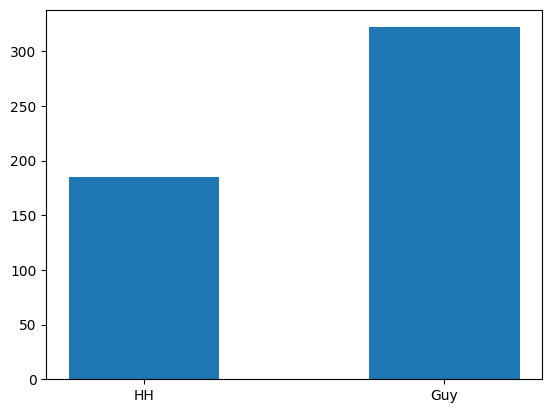

In [ ]:
sources = ['HH', 'Guy']
plt.bar(sources, [n_HH,n_Guys], width=0.5, align='center')
plt.show()

In [ ]:
os.mkdir(BASE_DIR + "Training")
os.mkdir(BASE_DIR + "Training/Volumes")
os.mkdir(BASE_DIR + "Training/Annotations")

os.mkdir(BASE_DIR + "Test")
os.mkdir(BASE_DIR + "Test/Volumes")
os.mkdir(BASE_DIR + "Test/Annotations")

**HH dataset**

In [ ]:
num_test_samples = round(n_HH*0.1) #  90% training set - 10% test set
indexes_list = np.array(range(n_HH))
random.shuffle(indexes_list)
# create two non overlapping indexes lists
test_indexes = indexes_list[:num_test_samples]
train_indexes = indexes_list[num_test_samples:n_HH]

Training set

In [ ]:
for i in train_indexes:
  volume_filename = HH_volumes_list[i]
  # get the annotation related to this volume
  annotation_filename = volume_filename[:-7]+"_annot.json"
  shutil.copy(HH_BASE_DIR + "Volumes/"+volume_filename,BASE_DIR + "Training/Volumes/")
  shutil.copy(HH_BASE_DIR + "Annotations/"+annotation_filename,BASE_DIR + "Training/Annotations/")

Do the same for the test set

In [ ]:
for i in test_indexes:
  volume_filename = HH_volumes_list[i]
  annotation_filename = volume_filename[:-7]+"_annot.json"
  shutil.copy(HH_BASE_DIR + "Volumes/"+volume_filename,BASE_DIR + "Test/Volumes/")
  shutil.copy(HH_BASE_DIR + "Annotations/"+annotation_filename,BASE_DIR + "Test/Annotations/")

**Guys dataset**

In [ ]:
num_test_samples = round(n_Guys*0.1) #  90% training set - 10% test set
indexes_list = np.array(range(n_Guys))
random.shuffle(indexes_list)
# create two non overlapping indexes lists
test_indexes = indexes_list[:num_test_samples]
train_indexes = indexes_list[num_test_samples:n_Guys]

Training set

In [ ]:
for i in train_indexes:
  volume_filename = Guys_volumes_list[i]
  # get the annotation related to this volume
  annotation_filename = volume_filename[:-7]+"_annot.json"
  shutil.copy(GUYS_BASE_DIR + "Volumes/"+volume_filename,BASE_DIR + "Training/Volumes/")
  shutil.copy(GUYS_BASE_DIR + "Annotations/"+annotation_filename,BASE_DIR + "Training/Annotations/")

Do the same for the test set

In [ ]:
for i in test_indexes:
  volume_filename = Guys_volumes_list[i]
  annotation_filename = volume_filename[:-7]+"_annot.json"
  shutil.copy(GUYS_BASE_DIR + "Volumes/"+volume_filename,BASE_DIR + "Test/Volumes/")
  shutil.copy(GUYS_BASE_DIR + "Annotations/"+annotation_filename,BASE_DIR + "Test/Annotations/")

Check the number of training and test samples:


*   Training set: 0.9x185 + 0.9x322
*   Test set: 0.1x185 + 0.1x322



In [ ]:
n_train_volumes = len(os.listdir(BASE_DIR + "Training/Volumes/"))
n_train_annotations = len(os.listdir(BASE_DIR + "Training/Annotations/"))
n_test_volumes = len(os.listdir(BASE_DIR + "Test/Volumes/"))
n_test_annotations = len(os.listdir(BASE_DIR + "Test/Annotations/"))

print(str(n_train_volumes) + " train volumes")
print(str(n_train_annotations) + " train annotations")
print(str(n_test_volumes) + " test volumes")
print(str(n_test_annotations) + " test annotations")

366 train volumes
366 train annotations
50 test volumes
50 test annotations


Save the filenames to file

In [ ]:
train_volumes = [vol+"\n" for vol in os.listdir(BASE_DIR+"Train/Volumes")]
F = open("train_volumes_T1.txt", "a")
F.writelines(train_volumes)
F.close()

In [ ]:
test_volumes = [vol+"\n" for vol in os.listdir(BASE_DIR+"Test/Volumes")]
F = open("test_volumes_T1.txt", "a")
F.writelines(test_volumes)
F.close()

# Split data in training and validation set

Create training and validation sets. The data stored in the "Train" directory are splitted in training and validation sets with a split percentage of 80%-20%

In [ ]:
filenames_list = os.listdir(BASE_DIR + "Training/Volumes")
print("Available training-validation samples = " + str(len(filenames_list)))

Available training-validation samples = 457


Visualize the number of HH and Guys samples

In [ ]:
print("HH samples = " + str(len([f for f in filenames_list if "HH" in f])))
print("Guys samples = " + str(len([f for f in filenames_list if "Guys" in f])))

HH samples = 167
Guys samples = 290


Random split

In [ ]:
n_samples = len(filenames_list)
num_val_samples = round(n_*0.2) #  80% training set - 20% validation set
indexes_list = np.array(range(n_samples))
random.shuffle(indexes_list)
# create two non overlapping indexes lists
validation_indexes = indexes_list[:num_val_samples]
train_indexes = indexes_list[num_val_samples:n_samples]
# get the filenames
training_samples = [filenames_list[i] for i in train_indexes]
validation_samples = [filenames_list[i] for i in validation_indexes]

Check that the two sets are not overlapped

In [ ]:
for i in range(len(training_samples)):
  if training_samples[i] in validation_samples:
    print("The two list are overlapped")

Move the validation samples in the "Validation" folder

In [ ]:
os.mkdir(BASE_DIR + "Validation")
os.mkdir(BASE_DIR + "Validation/Volumes")
os.mkdir(BASE_DIR + "Validation/Annotations")

In [ ]:
for volume_filename in validation_samples:
  # get the annotation related to this volume
  annotation_filename = volume_filename[:-7]+"_annot.json"
  shutil.move(BASE_DIR + "Training/Volumes/"+volume_filename,BASE_DIR + "Validation/Volumes/")
  shutil.move(BASE_DIR + "Training/Annotations/"+annotation_filename,BASE_DIR + "Validation/Annotations/")

In [ ]:
n_train_volumes = len(os.listdir(BASE_DIR + "Training/Volumes/"))
n_train_annotations = len(os.listdir(BASE_DIR + "Training/Annotations/"))
n_validation_volumes = len(os.listdir(BASE_DIR + "Validation/Volumes/"))
n_validation_annotations = len(os.listdir(BASE_DIR + "Validation/Annotations/"))

print(str(n_train_volumes) + " train volumes")
print(str(n_train_annotations) + " train annotations")
print(str(n_validation_volumes) + " validation volumes")
print(str(n_validation_annotations) + " validation annotations")

366 train volumes
366 train annotations
91 validation volumes
91 validation annotations


In [ ]:
validation_volumes = [vol+"\n" for vol in os.listdir(BASE_DIR+"Validation/Volumes")]
F = open("validation_volumes_T1.txt", "a")
F.writelines(validation_volumes)
F.close()

Plot the 3 sets cardinalities

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

n_train = len(os.listdir(BASE_DIR + "Training/Volumes/"))
n_validation = len(os.listdir(BASE_DIR + "Validation/Volumes/"))
n_test = len(os.listdir(BASE_DIR + "Test/Volumes/"))
n_tot = n_train + n_validation + n_test

train_HH = len([vol for vol in os.listdir(BASE_DIR + "Training/Volumes/") if "HH" in vol])
train_Guy = n_train - train_HH
validation_HH = len([vol for vol in os.listdir(BASE_DIR + "Validation/Volumes/") if "HH" in vol])
validation_Guy = n_validation - validation_HH
test_HH = len([vol for vol in os.listdir(BASE_DIR + "Test/Volumes/") if "HH" in vol])
test_Guy = n_test - test_HH

fig = make_subplots(
    rows=1, cols=4,
    specs=[
           [{"type": "bar"},{"type": "pie"}, {"type": "pie"}, {"type": "pie"}],
           ],
    column_widths=[0.7, 0.3,0.3,0.3]
)

fig.add_trace(go.Bar(x=["Test"],y=[n_test],name="Test",text=str(n_test)+" ("+str(round(n_test*100/n_tot))+"%)"), row=1, col=1)
fig.add_trace(go.Bar(x=["Validation"],y=[n_validation],name="Validation",text=str(n_validation)+" ("+str(round(n_validation*100/n_tot))+"%)"), row=1, col=1)
fig.add_trace(go.Bar(x=["Training"],y=[n_train],name="Training",text=str(n_train)+" ("+str(round(n_train*100/n_tot))+"%)"), row=1, col=1)

#fig.add_trace(go.Pie(values=[train_HH, train_Guy],labels=["HH","Guy"],title='Training set',textinfo='label+percent', hole=.4), row=1, col=2)
#fig.add_trace(go.Pie(values=[validation_HH, validation_Guy],labels=["HH","Guy"],title='Validation set',textinfo='label+percent', hole=.4), row=1, col=3)
#fig.add_trace(go.Pie(values=[test_HH, test_Guy],labels=["HH","Guy"],title='Test set',textinfo='label+percent', hole=.4), row=1, col=4)

fig.update_layout(showlegend=False)
fig.update_traces(textfont_size=20)
fig.update_layout(
    xaxis_tickfont_size=15,
    yaxis=dict(
        title='Number of volumes',
        titlefont_size=16,
        tickfont_size=15,
    )
)

# Dataset inspection

In [ ]:
SAMPLE_VOLUME_PATH = BASE_DIR + "Train/Volumes/IXI002-Guys-0828-T1.nii.gz"
SAMPLE_VOLUME_ANNOTATION_PATH = BASE_DIR + "Train/Annotations/IXI002-Guys-0828-T1_annot.json"

Voxel dimension

In [ ]:
volume_header = nib.load(SAMPLE_VOLUME_PATH).header
sx, sy, sz = volume_header.get_zooms()
print(str(sx) + " mm - " + str(sy) + " mm - " + str(sz) + " mm")

0.9375 mm - 0.9375 mm - 1.199997 mm


Volumes dimensions

In [ ]:
widths = []
heigths = []
depths = []
HH_volumes_list = os.listdir(HH_BASE_DIR + "Volumes")
for vol in HH_volumes_list:
  vol_shape = read_nifti_file(HH_BASE_DIR + "Volumes/" + vol).shape
  widths.append(vol_shape[0])
  heigths.append(vol_shape[1])
  depths.append(vol_shape[2])

Guys_volumes_list = os.listdir(GUYS_BASE_DIR + "Volumes")
for vol in Guys_volumes_list:
  vol_shape = read_nifti_file(GUYS_BASE_DIR + "Volumes/" + vol).shape
  widths.append(vol_shape[0])
  heigths.append(vol_shape[1])
  depths.append(vol_shape[2])

widths = set(widths)
heigths = set(heigths)
depths = set(depths)

In [ ]:
print("Volumes widths: " + str(widths))
print("Volumes heigths: " + str(heigths))
print("Volumes depths: " + str(depths))

Volumes widths: {256}
Volumes heigths: {256}
Volumes depths: {130, 140, 150}


Volume visualization

[[507. 480. 477. 512. 499. 495. 490. 490. 485. 473.]
 [510. 504. 496. 499. 502. 490. 510. 490. 497. 479.]
 [448. 522. 532. 480. 504. 499. 513. 493. 504. 509.]
 [299. 432. 500. 500. 501. 501. 505. 496. 499. 449.]
 [201. 270. 398. 477. 514. 503. 518. 471. 412. 277.]
 [255. 149. 254. 361. 469. 464. 466. 392. 242. 162.]
 [343. 156. 137. 241. 316. 354. 348. 272. 112. 208.]
 [371. 266. 107. 162. 170. 269. 277. 164. 106. 271.]
 [378. 360. 137. 120. 124. 261. 261. 106. 148. 292.]
 [383. 394. 153. 104. 121. 266. 265.  91. 156. 315.]]


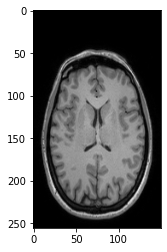

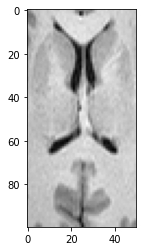

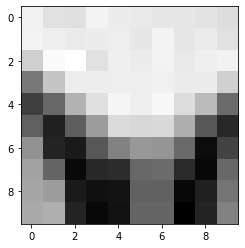

In [ ]:
volume = read_nifti_file(SAMPLE_VOLUME_PATH)

plt.imshow(volume[:,150,:],cmap="gray")
plt.figure()
plt.imshow(volume[100:200,150,50:100],cmap="gray")
plt.figure()
print(volume[110:120,150,70:80])
plt.imshow(volume[110:120,150,70:80],cmap="gray")

Montage of slices

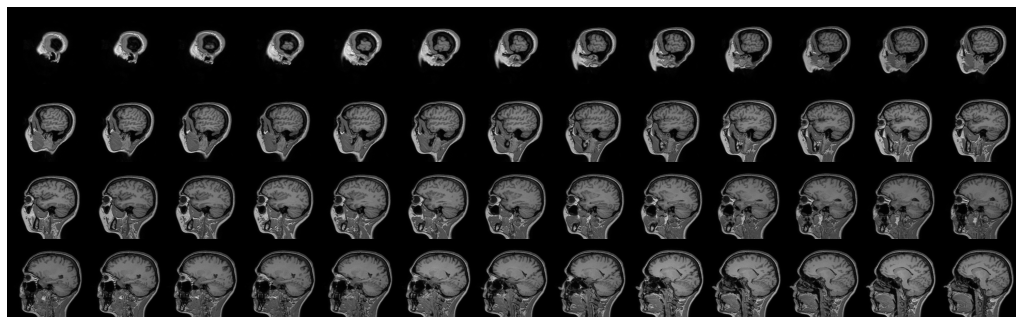

In [ ]:
volume = read_nifti_file(SAMPLE_VOLUME_PATH)
num_rows = 4
num_columns = 13
starting_index = 15

heights = [256 for i in range(num_rows)]
widths = [256 for j in range(num_columns)]
fig_width = 14.0
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(
    num_rows, num_columns,
    figsize=(fig_width, fig_height),
    gridspec_kw={"height_ratios": heights},
)

for i in range(num_rows):
  for j in range(num_columns):
    index = starting_index + (i*num_columns) + j
    axarr[i, j].imshow(np.rot90(volume[:,:,index]), cmap="gray")
    axarr[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

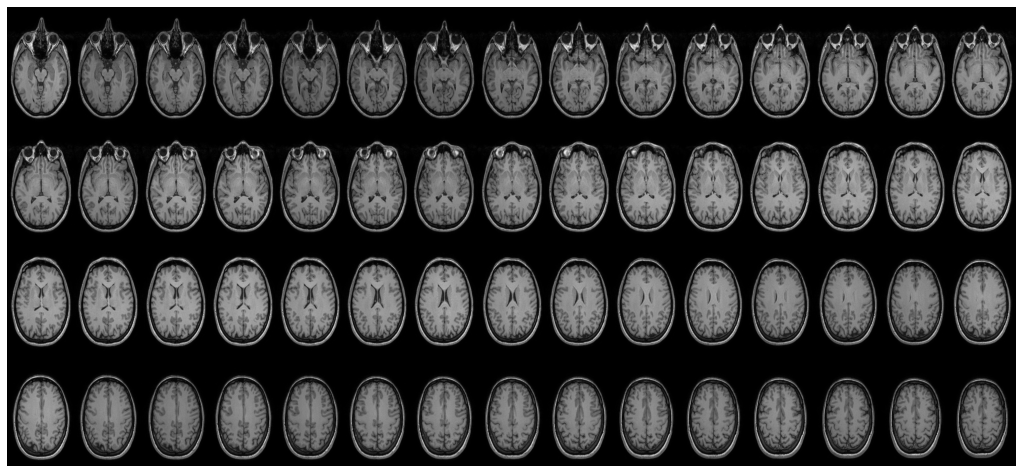

In [ ]:
volume = read_nifti_file(SAMPLE_VOLUME_PATH)
num_rows = 4
num_columns = 15
starting_index = 120

widths = [150 for i in range(num_columns)]
heights = [256 for j in range(num_rows)]
fig_width = 14.0
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(
    num_rows, num_columns,
    figsize=(fig_width, fig_height),
    gridspec_kw={"height_ratios": heights},
)

for i in range(num_rows):
  for j in range(num_columns):
    index = starting_index + (i*num_columns) + j
    axarr[i, j].imshow(volume[:,index,:], cmap="gray")
    axarr[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

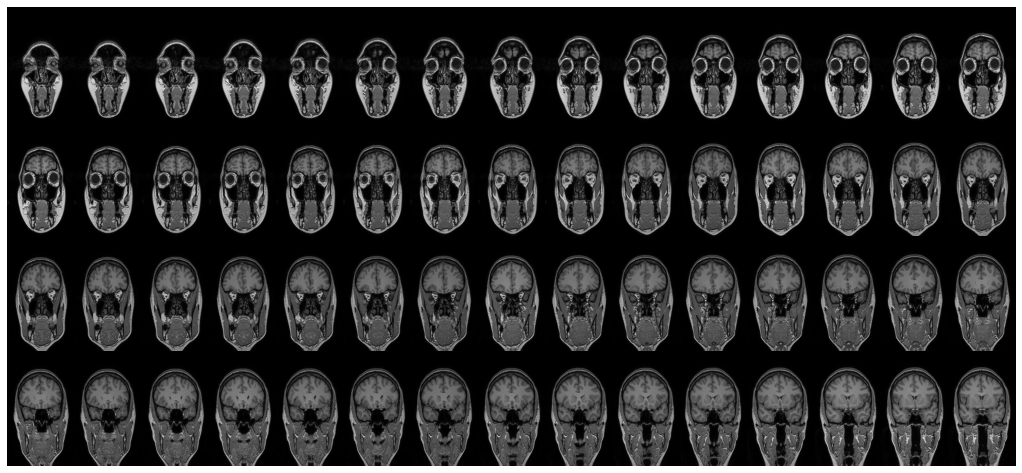

In [ ]:
volume = read_nifti_file(SAMPLE_VOLUME_PATH)
num_rows = 4
num_columns = 15
starting_index = 60

heights = [256 for i in range(num_rows)]
widths = [150 for j in range(num_columns)]
fig_width = 14.0
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(
    num_rows, num_columns,
    figsize=(fig_width, fig_height),
    gridspec_kw={"height_ratios": heights},
)

for i in range(num_rows):
  for j in range(num_columns):
    index = starting_index + (i*num_columns) + j
    axarr[i, j].imshow(np.rot90(volume[index,:,:],2), cmap="gray")
    axarr[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

World to voxel coordinates

In [ ]:
scan = nib.load(SAMPLE_VOLUME_PATH)
affine_matrix = scan.affine
inverse_affine_matrix = npl.inv(affine_matrix)
print(inverse_affine_matrix)

points = get_coordinates_list(SAMPLE_VOLUME_ANNOTATION_PATH)
for i,point in zip(range(4),points):
  # convert from LPS to RAS
  point[0] = -point[0]
  point[1] = -point[1]
  print("Point " + str(i+1) + ": " + str(point))

  #homogeneus space
  point = np.append(point,1)

  voxel_coord = np.dot(inverse_affine_matrix, point)

  print(voxel_coord)

[[ 2.73667113e-17 -1.05853420e+00  1.31465292e-01  1.38092154e+02]
 [ 2.20351694e-16  1.31465292e-01  1.05853420e+00  1.03356119e+02]
 [ 8.33335453e-01  0.00000000e+00  0.00000000e+00  7.38667650e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Point 1: [-0.02271858839270635, -16.12157792426288, 22.449253811828044]
[158.10869299 124.99999349  73.8478328    1.        ]
Point 2: [1.5442031233332898, 27.141309006409145, 42.88468673135769]
[114.99999793 152.31916607  75.15360421   1.        ]
Point 3: [32.9167495753816, 66.97310407270604, 13.700676968971194]
[ 68.99999645 126.66339234 101.29745941   1.        ]
Point 4: [-32.96560327421295, 68.35456041601003, 17.21735915089407]
[ 67.99999932 130.56753424  46.39535908   1.        ]


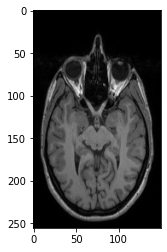

In [ ]:
volume = read_nifti_file(SAMPLE_VOLUME_ANNOTATION_PATH)
plt.imshow(volume[:,125,:],cmap="gray")

Coordinates normalization

In [ ]:
volume_shape = read_nifti_file(SAMPLE_VOLUME_PATH).shape
scan = nib.load(SAMPLE_VOLUME_PATH)
affine_matrix = scan.affine
inverse_affine_matrix = npl.inv(affine_matrix)
coords = []
points = get_coordinates_list(SAMPLE_VOLUME_ANNOTATION_PATH)
volume_target = np.array([])
for p in points:
  # from world to voxel coordinates
  voxel_coords = get_voxel_coordinates(SAMPLE_VOLUME_PATH,p)
  for i in range(3):
    volume_target = np.append(volume_target, voxel_coords[i])

#convert from float64 to float32 numpy
volume_target = volume_target.astype("float32")

print(volume_target)
print("Normalized coordinates")
print(normalize_voxel_coords(volume_target,volume_shape[0],volume_shape[1],volume_shape[2]))

[158.10869 124.99999  73.84783 115.      152.31917  75.1536   69.
 126.66339 101.29746  68.      130.56754  46.39536]
Normalized coordinates
[ 0.23522413 -0.02343756 -0.01536224 -0.1015625   0.1899935   0.00204803
 -0.4609375  -0.01044226  0.35063285 -0.46875     0.02005887 -0.38139522]


# Utility Functions

Function used to read a nifti (.nii) file. It returns a 3d numpy array.

In [ ]:
def read_nifti_file(filepath):
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

Function that read the annotation file (.json) and return the related list of coordinates

In [ ]:
def get_coordinates_list(filepath):

  f = open(filepath)
  json_dict = json.load(f)
  point_list = json_dict["markups"][0]["controlPoints"]

  coordinates_list = []
  for point in point_list:
    coordinates_list.append(point["position"])

  f.close()

  return coordinates_list

Function to convert the coordinates of a point in the reference space into voxel coordinates to use for the 3D numpy array that represents the volume

In [ ]:
def get_voxel_coordinates(volume_filepath, reference_space_coordinates):

  reference_space_point = np.copy(reference_space_coordinates)

  scan = nib.load(volume_filepath)
  affine_matrix = scan.affine
  inverse_affine_matrix = npl.inv(affine_matrix)

  # convert from LPS to RAS
  reference_space_point[0] = -reference_space_point[0]
  reference_space_point[1] = -reference_space_point[1]

  voxel_coord = apply_affine(inverse_affine_matrix, reference_space_point)

  return voxel_coord

In [ ]:
def get_world_coordinates(volume_filepath, voxel_coordinates):

  voxel_space_point = np.copy(voxel_coordinates)

  scan = nib.load(volume_filepath)
  affine_matrix = scan.affine

  world_coord = apply_affine(affine_matrix, voxel_space_point)

  return world_coord

In [ ]:
voxel_coord = get_voxel_coordinates(BASE_DIR + "Train/Volumes/IXI002-Guys-0828-T1.nii.gz",[-0.02271858839270635, -16.12157792426288, 22.449253811828045])
print(voxel_coord)
world_coord = get_world_coordinates(BASE_DIR + "Train/Volumes/IXI002-Guys-0828-T1.nii.gz", voxel_coord)
print(world_coord)

[123.97820996 129.23884937  73.88569721]
[ 0.02271859 16.12157792 22.44925381]


Utility function to plot the traning and validation loss trends epoch by epoch

In [ ]:
def plot_metrics(history):

  metrics = ['loss', 'mae']
  plt.figure(figsize=(12,10))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.style.use("ggplot")
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()

  return plt

In [ ]:
def plot_metrics_focus(history, last_n_epochs = 10):

  metrics = ['loss', 'mae']
  plt.figure(figsize=(12,10))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.style.use("ggplot")
    plt.plot(history.epoch[-last_n_epochs:], history.history[metric][-last_n_epochs:], label='Train')
    plt.plot(history.epoch[-last_n_epochs:], history.history['val_'+metric][-last_n_epochs:], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()

  return plt

In [ ]:
def plot_metrics_pytorch(train_loss_history, val_loss_history):
  # plot the model training history
  N = len(train_loss_history)
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), train_loss_history, label="train_loss")
  plt.plot(np.arange(0, N), val_loss_history, label="val_loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

  return plt

In [ ]:
def plot_metrics_csv(csv_filepath):

  df = pd.read_csv(csv_filepath)
  pd.set_option('mode.chained_assignment', None) # avoid warning
  for i in range(len(df)):
    df["epoch"][i] = i

  metrics = ['loss', 'mae']
  plt.figure(figsize=(12,10))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.style.use("ggplot")
    plt.plot(df["epoch"], df[metric], label='Train')
    plt.plot(df["epoch"], df['val_'+metric], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()

  return plt

Function to resample a volume

In [ ]:
def resample_volume(volume,desired_width,desired_height,desired_depth):

  # Get current depth
  current_depth = volume.shape[-1]
  current_width = volume.shape[0]
  current_height = volume.shape[1]
  # Compute depth factor
  depth = current_depth / desired_depth
  width = current_width / desired_width
  height = current_height / desired_height
  depth_factor = 1 / depth
  width_factor = 1 / width
  height_factor = 1 / height
  # Resize
  volume = ndimage.zoom(volume, (width_factor, height_factor, depth_factor), order=1)

  return volume

Function to compute the average euclidean distance between the 4 predicted points and the actual ones. This distance is a measure of the predictions' accuracy.

In [ ]:
def compute_euclidean_distance(y_true, y_pred):

  dist_1 = 0
  for i in range(3):
    diff = pow(y_pred[i]-y_true[i],2)
    dist_1 += diff
  dist_1 = math.sqrt(dist_1)

  dist_2 = 0
  for i in range(3,6):
    diff = pow(y_pred[i]-y_true[i],2)
    dist_2 += diff
  dist_2 = math.sqrt(dist_2)

  dist_3 = 0
  for i in range(6,9):
    diff = pow(y_pred[i]-y_true[i],2)
    dist_3 += diff
  dist_3 = math.sqrt(dist_3)

  dist_4 = 0
  for i in range(9,12):
    diff = pow(y_pred[i]-y_true[i],2)
    dist_4 += diff
  dist_4 = math.sqrt(dist_4)

  return (dist_1 + dist_2 + dist_3 + dist_4)/4, [dist_1, dist_2, dist_3, dist_4]

Save a prediction to an ".obj" file

In [ ]:
def write_obj_file(points,filename):
  ''' Write an ".obj" file contatining 4 three-dimensional points'''

  f = open(filename + ".obj", "w")

  for i in range(4):
    f.write("v")
    for j in range(i*3,(i*3)+3):
      f.write(" " + str(points[j]))
    if i < 3:
      f.write("\n")

  f.close()

Evaluate euclidean distance in terms of voxels and millimeters

In [ ]:
def evaluate_euclidean_distance(model,generator):
  '''
  Return the average euclidean distance between the predicted and the actual points. The distance is evaluated on de-normalized coordinates
  '''

  generator_indices = generator.indices
  actual_outputs = copy.deepcopy(generator.target)
  actual_outputs = [actual_outputs[i] for i in generator_indices] # reorder
  filenames_list = copy.deepcopy(generator.filepath)
  filenames_list = [filenames_list[i] for i in generator_indices] # reorder
  predictions = model.predict(generator)

  average_euclidean_distance_voxel = 0
  average_euclidean_distance_mm = 0
  point_average_euclidean_distance_mm = [0,0,0,0] # average euclidean distance for each of the 4 points

  for actual_output, prediction, filename in zip(actual_outputs,predictions,filenames_list):

    # get volume shape to denormalize the coordinates
    width, height, depth = read_nifti_file(filename).shape

    # denormalize
    prediction = denormalize_voxel_coords(prediction, width, height, depth)
    actual_output = denormalize_voxel_coords(actual_output, width, height, depth)

    # voxel coordinates
    average_euclidean_distance_single_prediction_voxel, _ = compute_euclidean_distance(actual_output,prediction)
    average_euclidean_distance_voxel += average_euclidean_distance_single_prediction_voxel

    # to world coordinates
    prediction[:3] = get_world_coordinates(filename,prediction[:3])
    prediction[3:6] = get_world_coordinates(filename,prediction[3:6])
    prediction[6:9] = get_world_coordinates(filename,prediction[6:9])
    prediction[9:] = get_world_coordinates(filename,prediction[9:])
    actual_output[:3] = get_world_coordinates(filename,actual_output[:3])
    actual_output[3:6] = get_world_coordinates(filename,actual_output[3:6])
    actual_output[6:9] = get_world_coordinates(filename,actual_output[6:9])
    actual_output[9:] = get_world_coordinates(filename,actual_output[9:])

    average_euclidean_distance_single_prediction, euclidean_distance_single_point = compute_euclidean_distance(actual_output,prediction) #mean euclidean distance for a single prediction
    average_euclidean_distance_mm += average_euclidean_distance_single_prediction
    for i in range(4):
      point_average_euclidean_distance_mm[i] += euclidean_distance_single_point[i]

  average_euclidean_distance_voxel /= len(predictions)
  average_euclidean_distance_mm /= len(predictions)
  for i in range(4):
    point_average_euclidean_distance_mm[i] /= len(predictions)

  #print("Average euclidean distance on the " + generator.name + " set\n\t"+str(average_euclidean_distance_voxel) + " voxels\n\t"+str(average_euclidean_distance_mm) + " millimeters")

  return average_euclidean_distance_voxel, average_euclidean_distance_mm, point_average_euclidean_distance_mm

Obtain the predictions on a given dataset and create a repository with the related ".obj" files, along with the desired outputs.

In [ ]:
def create_obj_files(repo_name, model, generator):

    if os.path.isdir(BASE_DIR + repo_name):
      shutil.rmtree(BASE_DIR + repo_name)

    os.mkdir(BASE_DIR + repo_name)

    generator_indices = generator.indices
    actual_outputs = copy.deepcopy(generator.target)
    actual_outputs = [actual_outputs[i] for i in generator_indices] # reorder
    filenames_list = copy.deepcopy(generator.filepath)
    filenames_list = [filenames_list[i] for i in generator_indices] # reorder
    predictions = model.predict(generator)

    #predictions = model.predict(generator)
    #targets = copy.deepcopy(generator.target)
    #filenames_list = copy.deepcopy(generator.filepath)
    #filenames_list = os.listdir(BASE_DIR + "Test/Volumes")

    for i,p,t in zip(range(len(predictions)),predictions,actual_outputs):

      p_filename =  "prediction_" + filenames_list[i].split("/")[6][:-7]
      t_filename = "target_" + filenames_list[i].split("/")[6][:-7]

      # get volume shape
      width, height, depth = read_nifti_file(filenames_list[i]).shape

      #de-normalize
      prediction = denormalize_voxel_coords(p, width, height, depth)
      target = denormalize_voxel_coords(t, width, height, depth)

      # to world coordinates
      prediction[:3] = get_world_coordinates(filenames_list[i],prediction[:3])
      prediction[3:6] = get_world_coordinates(filenames_list[i],prediction[3:6])
      prediction[6:9] = get_world_coordinates(filenames_list[i],prediction[6:9])
      prediction[9:] = get_world_coordinates(filenames_list[i],prediction[9:])
      target[:3] = get_world_coordinates(filenames_list[i],target[:3])
      target[3:6] = get_world_coordinates(filenames_list[i],target[3:6])
      target[6:9] = get_world_coordinates(filenames_list[i],target[6:9])
      target[9:] = get_world_coordinates(filenames_list[i],target[9:])

      #write the obj files
      write_obj_file(prediction,BASE_DIR +repo_name+"/"+p_filename)
      write_obj_file(target,BASE_DIR +repo_name+"/"+t_filename)

Utility function to show the performances of a given model on a set of data

In [ ]:
def show_model_performances(model, generators_list):

  for generator in generators_list:

    results = model.evaluate(generator,verbose=0)
    average_euclidean_distance_voxel, average_euclidean_distance_mm, point_average_euclidean_distance_mm = evaluate_euclidean_distance(model,generator)
    print(generator.name + " set")
    print("\tMean Squared Error : " + str(results[0]))
    print("\tMean Absolute Error : " + str(results[1]))
    #print("\t\tOn average, the predictions are " + str(format((results[1]*100)/2,'.2f')) + "% off") # the model outputs are number normalized in the range [-1,1], therefore the maximum error is 2
    print("\tAverage euclidean distance")
    print("\t\t" + str(format(average_euclidean_distance_voxel,'.2f')) + " voxels\n\t\t"+str(format(average_euclidean_distance_mm,'.2f')) + " millimeters")
    print("\tSingle point average euclidean distance")
    for i in range(4):
      print("\t\tPoint " + str(i) + " : " + str(format(point_average_euclidean_distance_mm[i],'.2f')) + " millimeters")
    print()

Function to evaluate the average euclidean distance between predictions and targets of the test set. Use this function with a pytorch model

In [ ]:
def evaluate_euclidean_distance_pytorch(model,dataLoader):
  '''
  Return the average euclidean distance between the predicted and the actual points. The distance is evaluated on de-normalized coordinates
  '''

  model.eval()

  average_euclidean_distance = 0

  for data, targets in dataLoader:

    data = data.to("cuda:0")

    predictions = model(data)
    predictions = predictions.cpu().data.numpy()

    for target, prediction in zip(targets,predictions):
      prediction = denormalize_voxel_coords(prediction)
      target = denormalize_voxel_coords(target)
      average_euclidean_distance += compute_euclidean_distance(target,prediction) #mean euclidean distance for a single prediction

  average_euclidean_distance /= len(dataLoader.dataset)

  return average_euclidean_distance

Normalization functions for the coordinates

In [ ]:
def normalize_voxel_coords(coords,width,height,depth):

    # normalization between -1 and 1
    for i in range(4):
      coords[i*3] = ((coords[i*3]/width)*2)-1
      coords[i*3 + 1] = ((coords[i*3 + 1]/height)*2)-1
      coords[i*3 + 2] = ((coords[i*3 + 2]/depth)*2)-1

    return coords

In [ ]:
def denormalize_voxel_coords(coords,width,height,depth):

    # de-normalization
    for i in range(4):
      coords[i*3] = (coords[i*3]+1)*(width/2)
      coords[i*3 + 1] = (coords[i*3 + 1]+1)*(height/2)
      coords[i*3 + 2] = (coords[i*3 + 2]+1)*(depth/2)

    return coords

Function to normalize a volume

In [ ]:
def normalize_volume(volume):
  ''' Function to normalize a volume with its mean and standard deviation '''

  nz   = np.nonzero(volume)
  mean = volume[nz].mean()
  std = volume[nz].std()

  volume[nz] = volume[nz] - mean
  volume[nz] = volume[nz] / std

  return volume

Function to generate the volumes and targets lists, given a certain folder path

In [ ]:
def generate_dataset(folder_path,resampling_shape=DEFAULT_RESAMPLING_SHAPE,start_idx=0,end_idx=0):
  '''
    volumes: list of 3d numpy arrays of shape [128,128,64]
    targets: list of 1d numpy arrays of 12 float32 values in the range [-1,1] representing the desidered outputs for the volumes
    filenames: list of strinfg representing the paths of the processed volumes
  '''

  volumes = []
  targets = []
  filenames = []

  if start_idx == 0 and end_idx == 0:
    filenames_list = os.listdir(folder_path + "Volumes") # consider the entire folder
  else:
    filenames_list = os.listdir(folder_path + "Volumes")[start_idx:end_idx] # consider only a subset of the folder

  for file_name,i in zip(filenames_list,tqdm(range(len(filenames_list)))):

    volume_filepath = folder_path + "Volumes/" + file_name

    filenames.append(volume_filepath)

    volume = read_nifti_file(volume_filepath)
    width, height, depth = volume.shape
    #convert from float64 to float32 numpy
    volume = volume.astype("float32")
    # resampling
    volume = resample_volume(volume,resampling_shape[0],resampling_shape[1],resampling_shape[2])
    # normalization
    volume = normalize_volume(volume)
    # add channel dimension as last dimension
    volume = np.expand_dims(volume,axis=-1)

    volumes.append(volume)

    annotation_path = folder_path + "Annotations/"+file_name[:-7]+"_annot.json"
    points = get_coordinates_list(annotation_path)
    volume_target = np.array([])

    for p in points:
      # from world to voxel coordinates
      voxel_coords = get_voxel_coordinates(volume_filepath,p)
      for i in range(3):
        volume_target = np.append(volume_target, voxel_coords[i])

    #convert from float64 to float32 numpy
    volume_target = volume_target.astype("float32")
    # normalization
    volume_target = normalize_voxel_coords(volume_target,width,height,depth)

    targets.append(volume_target)

  return volumes, targets, filenames

**"Generator"** to work in Keras with a large amount of data and avoid OutOfMemory problems. It allows us to load in memory only one batch of data at time, in an "online" fashion.

In [ ]:
class Generator(Sequence):

    def __init__(self, volume_set, target_set, filepath_set, generator_name, batch_size=BATCH_SIZE):
        self.volume, self.target, self.filepath = volume_set, target_set, filepath_set

        self.name = generator_name
        self.batch_size = batch_size
        self.indices = np.arange(len(self.volume))

    def __len__(self):
        return int(np.ceil(len(self.volume) / self.batch_size))

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size] # get the "idx" batch of data
        volume_batch = []
        target_batch = []
        for i in inds:
          volume_batch.append(self.volume[i])
          target_batch.append(self.target[i])

        return np.array(volume_batch), np.array(target_batch)

    def on_epoch_end(self):
      if self.name is "Train": # shuffle the data only if in training
        np.random.shuffle(self.indices)

Generator to train a model with an augmented training set, loading in memory only a single batch of data at a time

In [ ]:
def get_bucket_starting_index(array,value):
    if value in array:
      return value
    idx = np.searchsorted(array, value, side="left")
    return array[idx-1]

In [ ]:
class Generator_Augmented_Trainset(Sequence):

    def __init__(self, h5path, indices, bucket_size, batch_size=BATCH_SIZE):

        self.h5path = h5path
        self.indices = indices # step = 1 volume
        self.n_volumes = len(self.indices)
        self.batch_size = batch_size
        self.h5f = h5py.File(self.h5path, "r")

        self.bucket_volumes = []
        self.bucket_targets = []
        self.bucket_size = bucket_size # expressed in number of volumes
        self.bucket_starting_index = -1
        self.bucket_starting_indexes = np.arange(0,self.n_volumes,step=self.bucket_size)


    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx): # idx are passed ordered, since the fit method is called with "Shuffle=False"

        new_bucket_starting_index = get_bucket_starting_index(self.bucket_starting_indexes,idx*self.batch_size) # index expressed in number of volumes

        if new_bucket_starting_index != self.bucket_starting_index:
          self.bucket_starting_index = new_bucket_starting_index
          bucket_inds = self.indices[self.bucket_starting_index:(self.bucket_starting_index + self.bucket_size)]
          original_bucket_inds = np.argsort(np.argsort(bucket_inds))
          bucket_inds.sort() # To read from the H5 file, the indexing elements must be in increasing order
          self.bucket_volumes = self.h5f["volumes"][bucket_inds]
          self.bucket_targets = self.h5f["targets"][bucket_inds]
          # re-order
          self.bucket_volumes = self.bucket_volumes[original_bucket_inds]
          self.bucket_targets = self.bucket_targets[original_bucket_inds]

        idx = (idx*self.batch_size) - self.bucket_starting_index  # range [0,bucket_size]

        if idx + 1 < len(self.bucket_targets):
          inds = [idx,idx+1] # suppose batch_size=2
        else:
          inds = [idx]

        volume_batch = []
        target_batch = []

        for i in inds:
          volume_batch.append(self.bucket_volumes[i])
          target_batch.append(self.bucket_targets[i])

        return np.array(volume_batch), np.array(target_batch)

    def on_epoch_end(self):
      np.random.shuffle(self.indices)

Utility functions to analyse the performances of the models on T1+T2 datasets

In [ ]:
def T1_T2_performances(model,generator):

  generator_indices = generator.indices
  actual_outputs = copy.deepcopy(generator.target)
  actual_outputs = [actual_outputs[i] for i in generator_indices] # reorder
  filenames_list = copy.deepcopy(generator.filepath)
  filenames_list = [filenames_list[i] for i in generator_indices] # reorder
  predictions = model.predict(generator)

  # considet a vector with 2 entries: one for the performances on the T1 volumes and one for the T2 volumes
  average_euclidean_distance_voxel = [0,0]
  average_euclidean_distance_mm = [0,0]
  point_average_euclidean_distance_mm = [[0,0,0,0],[0,0,0,0]] # average euclidean distance for each of the 4 points
  # 0: T1 volume, 1: T2 volume
  T1_T2_index = 0

  for actual_output, prediction, filename in zip(actual_outputs,predictions,filenames_list):

    # T1 or T2 volume ?
    if "T1" in filename:
      T1_T2_index = 0
    else:
      T1_T2_index = 1

    # get volume shape to denormalize the coordinates
    width, height, depth = read_nifti_file(filename).shape

    # denormalize
    prediction = denormalize_voxel_coords(prediction, width, height, depth)
    actual_output = denormalize_voxel_coords(actual_output, width, height, depth)

    # voxel coordinates
    average_euclidean_distance_single_prediction_voxel, _ = compute_euclidean_distance(actual_output,prediction)
    average_euclidean_distance_voxel[T1_T2_index] += average_euclidean_distance_single_prediction_voxel

    # to world coordinates
    prediction[:3] = get_world_coordinates(filename,prediction[:3])
    prediction[3:6] = get_world_coordinates(filename,prediction[3:6])
    prediction[6:9] = get_world_coordinates(filename,prediction[6:9])
    prediction[9:] = get_world_coordinates(filename,prediction[9:])
    actual_output[:3] = get_world_coordinates(filename,actual_output[:3])
    actual_output[3:6] = get_world_coordinates(filename,actual_output[3:6])
    actual_output[6:9] = get_world_coordinates(filename,actual_output[6:9])
    actual_output[9:] = get_world_coordinates(filename,actual_output[9:])

    average_euclidean_distance_single_prediction, euclidean_distance_single_point = compute_euclidean_distance(actual_output,prediction) #mean euclidean distance for a single prediction
    average_euclidean_distance_mm[T1_T2_index] += average_euclidean_distance_single_prediction
    for i in range(4):
      point_average_euclidean_distance_mm[T1_T2_index][i] += euclidean_distance_single_point[i]

  T1_predictions = len([filename for filename in filenames_list if "T1" in filename])
  T2_predictions = len([filename for filename in filenames_list if "T2" in filename])
  average_euclidean_distance_voxel[0] /= T1_predictions
  average_euclidean_distance_mm[0] /= T1_predictions
  average_euclidean_distance_voxel[1] /= T2_predictions
  average_euclidean_distance_mm[1] /= T2_predictions

  for i in range(4):
    point_average_euclidean_distance_mm[0][i] /= T1_predictions
  for i in range(4):
    point_average_euclidean_distance_mm[1][i] /= T2_predictions

  return average_euclidean_distance_voxel, average_euclidean_distance_mm, point_average_euclidean_distance_mm

In [ ]:
def show_T1_T2_performances(model,generators_list):

  for generator in generators_list:

      average_euclidean_distance_voxel, average_euclidean_distance_mm, point_average_euclidean_distance_mm = T1_T2_performances(model,generator)
      print(generator.name + " set")
      print("\tAverage euclidean distance on T1 volumes")
      print("\t\t" + str(format(average_euclidean_distance_voxel[0],'.2f')) + " voxels\n\t\t" + str(format(average_euclidean_distance_mm[0],'.2f')) + " millimeters")
      print("\t\tSingle point average euclidean distance on T1 volumes")
      for i in range(4):
        print("\t\t\tPoint " + str(i) + " : " + str(format(point_average_euclidean_distance_mm[0][i],'.2f')) + " millimeters")
      print()
      print("\tAverage euclidean distance on T2 volumes")
      print("\t\t" + str(format(average_euclidean_distance_voxel[1],'.2f')) + " voxels\n\t\t" + str(format(average_euclidean_distance_mm[1],'.2f')) + " millimeters")
      print("\t\tSingle point average euclidean distance on T2 volumes")
      for i in range(4):
        print("\t\t\tPoint " + str(i) + " : " + str(format(point_average_euclidean_distance_mm[1][i],'.2f')) + " millimeters")
      print()

# Experiments - No data augmentation

In [ ]:
train_volumes, train_targets, train_filenames = generate_dataset(BASE_DIR + "Train/")
validation_volumes, validation_targets, validation_filenames = generate_dataset(BASE_DIR + "Validation/")
test_volumes, test_targets, test_filenames = generate_dataset(BASE_DIR + "Test/")

train_generator = Generator(train_volumes,train_targets,train_filenames,"Train")
validation_generator = Generator(validation_volumes,validation_targets,validation_filenames,"Validation")
test_generator = Generator(test_volumes,test_targets,test_filenames,"Test")

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## Base CNN

In [ ]:
def cnn_scratch():

    inputs = keras.Input((128, 128, 64, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.GlobalAveragePooling3D()(x)

    x = layers.Dense(units=128, activation="relu")(x)

    outputs = layers.Dense(units=12, activation="linear")(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss="mse", metrics=["mae"], optimizer="adam")

    return model

In [ ]:
model = cnn_scratch()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 30, 14, 64)   0         
 3D)                                                             
                                                             

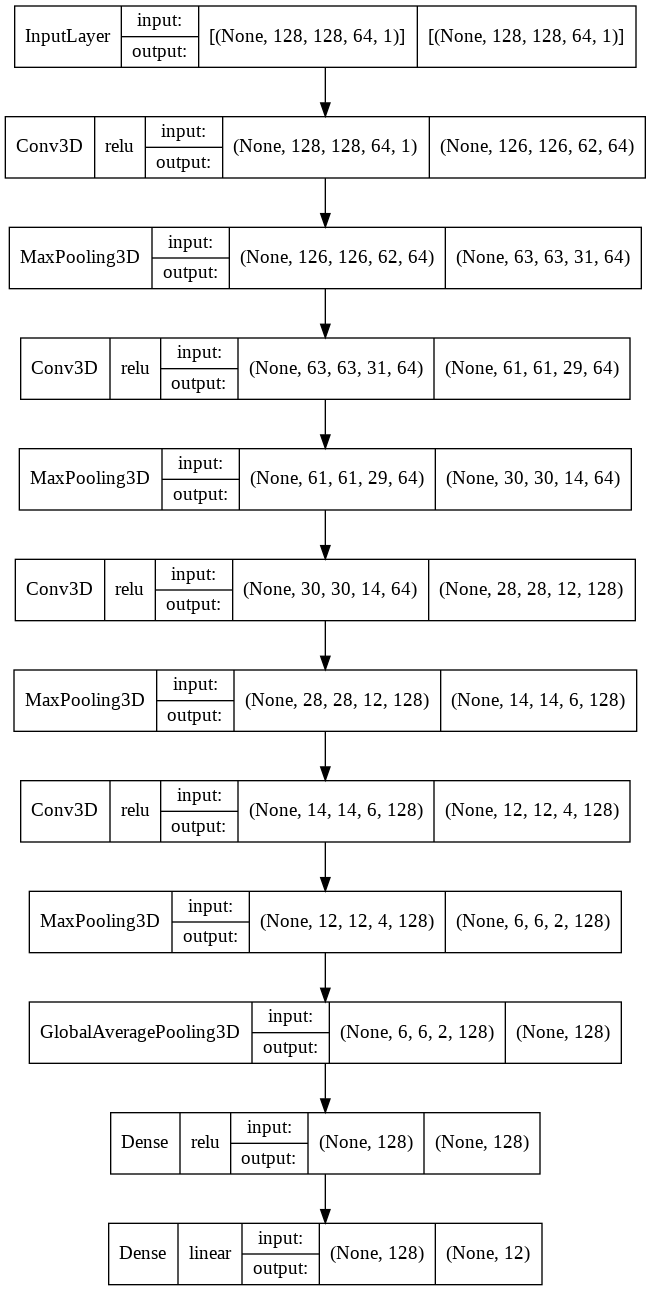

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_activations=True, show_layer_names=False)

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=60)

Epoch 1/60
183/183 [==============================] - 91s 410ms/step - loss: 0.0115 - mae: 0.0638 - val_loss: 0.0036 - val_mae: 0.0431
Epoch 2/60
183/183 [==============================] - 75s 409ms/step - loss: 0.0045 - mae: 0.0485 - val_loss: 0.0037 - val_mae: 0.0439
Epoch 3/60
183/183 [==============================] - 75s 408ms/step - loss: 0.0042 - mae: 0.0467 - val_loss: 0.0038 - val_mae: 0.0444
Epoch 4/60
183/183 [==============================] - 74s 407ms/step - loss: 0.0041 - mae: 0.0465 - val_loss: 0.0037 - val_mae: 0.0444
Epoch 5/60
183/183 [==============================] - 75s 407ms/step - loss: 0.0037 - mae: 0.0443 - val_loss: 0.0033 - val_mae: 0.0419
Epoch 6/60
183/183 [==============================] - 75s 407ms/step - loss: 0.0034 - mae: 0.0419 - val_loss: 0.0030 - val_mae: 0.0389
Epoch 7/60
183/183 [==============================] - 74s 407ms/step - loss: 0.0037 - mae: 0.0439 - val_loss: 0.0031 - val_mae: 0.0405
Epoch 8/60
183/183 [==============================] - 7

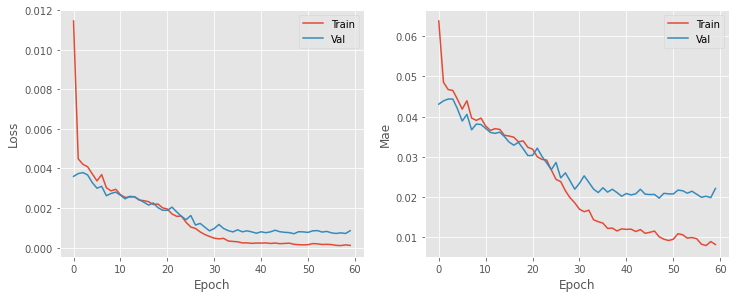

In [ ]:
plot_metrics(history).show()

In [ ]:
show_model_performances(model,[train_generator,validation_generator,test_generator])

Train set
	Mean Squared Error : 0.0001564361882628873
	Mean Absolute Error : 0.00955768208950758
	Average euclidean distance
		2.30 voxels
		2.22 millimeters
	Single point average euclidean distance
		Point 0 : 1.60 millimeters
		Point 1 : 1.58 millimeters
		Point 2 : 2.79 millimeters
		Point 3 : 2.89 millimeters

Validation set
	Mean Squared Error : 0.0008521484560333192
	Mean Absolute Error : 0.02210206538438797
	Average euclidean distance
		5.41 voxels
		5.18 millimeters
	Single point average euclidean distance
		Point 0 : 3.95 millimeters
		Point 1 : 4.78 millimeters
		Point 2 : 6.12 millimeters
		Point 3 : 5.86 millimeters

Test set
	Mean Squared Error : 0.000766125915106386
	Mean Absolute Error : 0.021389329805970192
	Average euclidean distance
		5.19 voxels
		4.98 millimeters
	Single point average euclidean distance
		Point 0 : 4.04 millimeters
		Point 1 : 4.77 millimeters
		Point 2 : 5.56 millimeters
		Point 3 : 5.56 millimeters



In [ ]:
model.save(BASE_DIR+"cnn1.h5")

In [ ]:
model = keras.models.load_model(BASE_DIR+"cnn1.h5")

In [ ]:
create_obj_files("Predictions_train_cnn1",model,train_generator)
create_obj_files("Predictions_val_cnn1",model,validation_generator)

In [ ]:
create_obj_files("Predictions_test_cnn1",model,test_generator)

## Base CNN - Flatten layer

In [ ]:
def cnn_scratch():

    inputs = keras.Input((128, 128, 64, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units=128, activation="relu")(x)

    outputs = layers.Dense(units=12, activation="linear")(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss="mse", metrics=["mae"], optimizer="adam")

    return model

In [ ]:
model = cnn_scratch()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 30, 14, 64)   0         
 3D)                                                             
                                                             

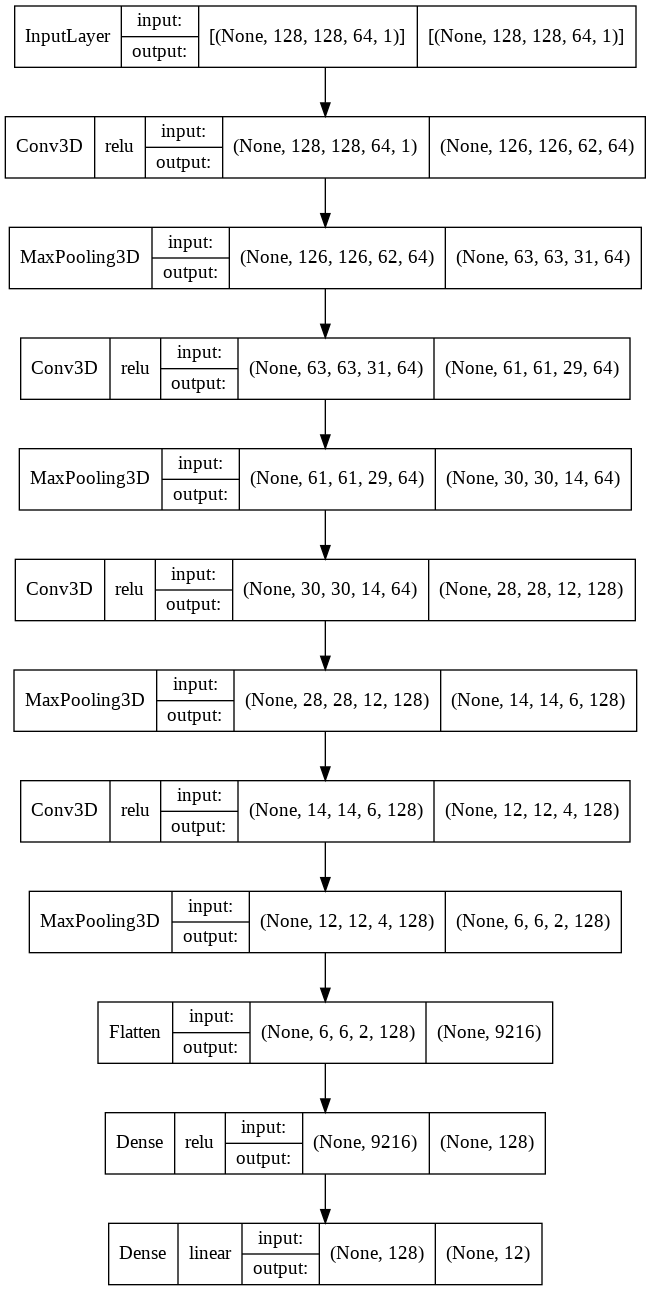

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_activations=True, show_layer_names=False)

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=60)

Epoch 1/60
183/183 [==============================] - 90s 406ms/step - loss: 0.0441 - mae: 0.0711 - val_loss: 0.0035 - val_mae: 0.0432
Epoch 2/60
183/183 [==============================] - 73s 401ms/step - loss: 0.0029 - mae: 0.0404 - val_loss: 0.0022 - val_mae: 0.0359
Epoch 3/60
183/183 [==============================] - 73s 401ms/step - loss: 0.0017 - mae: 0.0316 - val_loss: 9.6699e-04 - val_mae: 0.0248
Epoch 4/60
183/183 [==============================] - 73s 401ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 6.7875e-04 - val_mae: 0.0204
Epoch 5/60
183/183 [==============================] - 73s 402ms/step - loss: 8.3702e-04 - mae: 0.0219 - val_loss: 7.0668e-04 - val_mae: 0.0206
Epoch 6/60
183/183 [==============================] - 73s 401ms/step - loss: 6.9100e-04 - mae: 0.0201 - val_loss: 6.4783e-04 - val_mae: 0.0202
Epoch 7/60
183/183 [==============================] - 73s 401ms/step - loss: 7.1519e-04 - mae: 0.0203 - val_loss: 5.1956e-04 - val_mae: 0.0180
Epoch 8/60
183/183 [===

In [ ]:
model.save(BASE_DIR + "scratch_60epochs.h5")

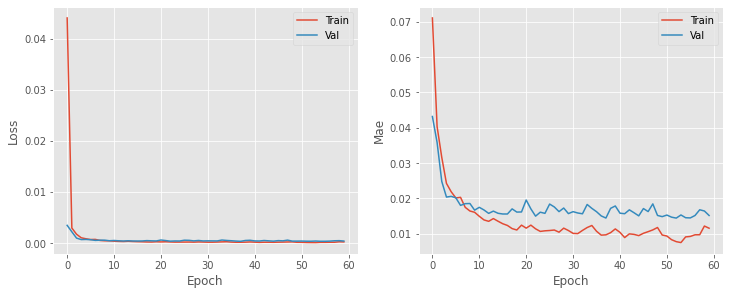

In [ ]:
plot_metrics(history).show()

In [ ]:
model = keras.models.load_model(BASE_DIR + "scratch_60epochs.h5")

In [ ]:
show_model_performances(model,[train_generator,validation_generator,test_generator])

Train set
	Mean Squared Error : 0.0001426862581865862
	Mean Absolute Error : 0.009419356472790241
	Average euclidean distance
		2.15 voxels
		2.10 millimeters
	Single point average euclidean distance
		Point 0 : 1.99 millimeters
		Point 1 : 1.97 millimeters
		Point 2 : 2.14 millimeters
		Point 3 : 2.32 millimeters

Validation set
	Mean Squared Error : 0.00038943730760365725
	Mean Absolute Error : 0.015177352353930473
	Average euclidean distance
		3.54 voxels
		3.45 millimeters
	Single point average euclidean distance
		Point 0 : 3.10 millimeters
		Point 1 : 3.46 millimeters
		Point 2 : 3.64 millimeters
		Point 3 : 3.61 millimeters

Test set
	Mean Squared Error : 0.00037492357660084963
	Mean Absolute Error : 0.015448316000401974
	Average euclidean distance
		3.46 voxels
		3.40 millimeters
	Single point average euclidean distance
		Point 0 : 2.94 millimeters
		Point 1 : 3.25 millimeters
		Point 2 : 3.78 millimeters
		Point 3 : 3.62 millimeters



In [ ]:
create_obj_files("Predictions_train_cnn2",model,train_generator)
create_obj_files("Predictions_val_cnn2",model,validation_generator)

In [ ]:
create_obj_files("Predictions_test_cnn2",model,test_generator)

## Base CNN - Without pooling

In [ ]:
def cnn_scratch():

    inputs = keras.Input((128, 128, 64, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units=128, activation="relu")(x)

    outputs = layers.Dense(units=12, activation="linear")(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss="mse", metrics=["mae"], optimizer="adam")

    return model

In [ ]:
model = cnn_scratch()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 30, 14, 64)   0         
 3D)                                                             
                                                             

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=60)

Epoch 1/60
183/183 [==============================] - 41s 169ms/step - loss: 0.4111 - mae: 0.1090 - val_loss: 0.0032 - val_mae: 0.0423
Epoch 2/60
183/183 [==============================] - 31s 169ms/step - loss: 0.0030 - mae: 0.0417 - val_loss: 0.0022 - val_mae: 0.0354
Epoch 3/60
183/183 [==============================] - 31s 172ms/step - loss: 0.0021 - mae: 0.0345 - val_loss: 0.0013 - val_mae: 0.0288
Epoch 4/60
183/183 [==============================] - 32s 175ms/step - loss: 0.0014 - mae: 0.0292 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 5/60
183/183 [==============================] - 32s 175ms/step - loss: 0.0013 - mae: 0.0274 - val_loss: 9.0512e-04 - val_mae: 0.0230
Epoch 6/60
183/183 [==============================] - 32s 175ms/step - loss: 0.0010 - mae: 0.0246 - val_loss: 9.0483e-04 - val_mae: 0.0235
Epoch 7/60
183/183 [==============================] - 32s 175ms/step - loss: 9.5522e-04 - mae: 0.0235 - val_loss: 7.2319e-04 - val_mae: 0.0215
Epoch 8/60
183/183 [===================

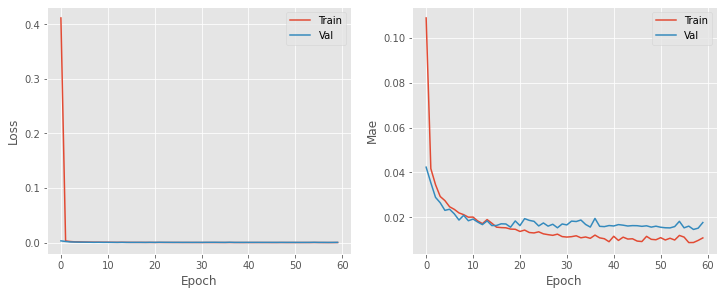

In [ ]:
plot_metrics(history).show()

In [ ]:
show_model_performances(model,[train_generator,validation_generator,test_generator])

Train set
	Mean Squared Error : 0.00023630134819541126
	Mean Absolute Error : 0.012258496135473251
	Average euclidean distance
		2.70 voxels
		2.66 millimeters
	Single point average euclidean distance
		Point 0 : 2.30 millimeters
		Point 1 : 2.43 millimeters
		Point 2 : 2.95 millimeters
		Point 3 : 2.98 millimeters

Validation set
	Mean Squared Error : 0.000488608202431351
	Mean Absolute Error : 0.01761011965572834
	Average euclidean distance
		3.95 voxels
		3.86 millimeters
	Single point average euclidean distance
		Point 0 : 3.20 millimeters
		Point 1 : 3.88 millimeters
		Point 2 : 4.24 millimeters
		Point 3 : 4.14 millimeters

Test set
	Mean Squared Error : 0.0005038362578488886
	Mean Absolute Error : 0.017421429976820946
	Average euclidean distance
		3.87 voxels
		3.81 millimeters
	Single point average euclidean distance
		Point 0 : 2.98 millimeters
		Point 1 : 3.41 millimeters
		Point 2 : 4.52 millimeters
		Point 3 : 4.32 millimeters



## Customized loss function (Euclidean distance)

In [ ]:
from keras import backend as K

def euclidean_distance_loss(y_true, y_pred):

    y_true = y_true[0]
    y_pred = y_pred[0]

    dist_1 = K.sqrt(K.sum(K.square(y_true[:3] - y_pred[:3]), axis=-1, keepdims=True))
    dist_2 = K.sqrt(K.sum(K.square(y_true[3:6] - y_pred[3:6]), axis=-1, keepdims=True))
    dist_3 = K.sqrt(K.sum(K.square(y_true[6:9] - y_pred[6:9]), axis=-1, keepdims=True))
    dist_4 = K.sqrt(K.sum(K.square(y_true[9:12] - y_pred[9:12]), axis=-1, keepdims=True))

    res = (dist_1 + dist_2 + dist_3 + dist_4)/4

    return res

In [ ]:
def cnn_euclidean_distance():

    inputs = keras.Input((128, 128, 64, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units=128, activation="relu")(x)

    outputs = layers.Dense(units=12, activation="linear")(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss=euclidean_distance_loss, metrics=["mae"], optimizer="adam")

    return model

In [ ]:
model = cnn_euclidean_distance()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_8 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 30, 30, 14, 64)   0         
 3D)                                                             
                                                           

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=60)

Epoch 1/60
183/183 [==============================] - 77s 409ms/step - loss: 0.1535 - mae: 0.0738 - val_loss: 0.0966 - val_mae: 0.0423
Epoch 2/60
183/183 [==============================] - 74s 404ms/step - loss: 0.0904 - mae: 0.0444 - val_loss: 0.0751 - val_mae: 0.0364
Epoch 3/60
183/183 [==============================] - 74s 404ms/step - loss: 0.0666 - mae: 0.0334 - val_loss: 0.0589 - val_mae: 0.0293
Epoch 4/60
183/183 [==============================] - 74s 404ms/step - loss: 0.0576 - mae: 0.0283 - val_loss: 0.0526 - val_mae: 0.0260
Epoch 5/60
183/183 [==============================] - 74s 404ms/step - loss: 0.0511 - mae: 0.0254 - val_loss: 0.0502 - val_mae: 0.0234
Epoch 6/60
183/183 [==============================] - 74s 403ms/step - loss: 0.0482 - mae: 0.0247 - val_loss: 0.0477 - val_mae: 0.0232
Epoch 7/60
183/183 [==============================] - 74s 403ms/step - loss: 0.0477 - mae: 0.0232 - val_loss: 0.0453 - val_mae: 0.0222
Epoch 8/60
183/183 [==============================] - 7

In [ ]:
model.save(BASE_DIR + "scratch_60epochs_euclideandistance.h5")

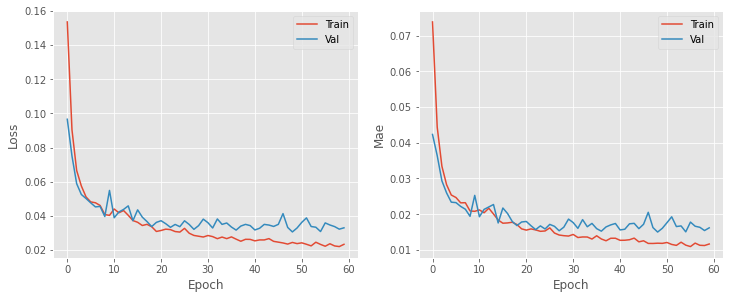

In [ ]:
plot_metrics(history).show()

In [ ]:
show_model_performances(model,[train_generator,validation_generator,test_generator])

Train set
	Mean Squared Error : 0.0221162810921669
	Mean Absolute Error : 0.01084026787430048
	Average euclidean distance
		2.50 voxels
		2.44 millimeters
	Single point average euclidean distance
		Point 0 : 2.08 millimeters
		Point 1 : 2.59 millimeters
		Point 2 : 2.48 millimeters
		Point 3 : 2.63 millimeters

Validation set
	Mean Squared Error : 0.03307471424341202
	Mean Absolute Error : 0.01618916541337967
	Average euclidean distance
		3.77 voxels
		3.67 millimeters
	Single point average euclidean distance
		Point 0 : 3.44 millimeters
		Point 1 : 4.09 millimeters
		Point 2 : 3.54 millimeters
		Point 3 : 3.62 millimeters

Test set
	Mean Squared Error : 0.03090442344546318
	Mean Absolute Error : 0.01613347977399826
	Average euclidean distance
		3.77 voxels
		3.68 millimeters
	Single point average euclidean distance
		Point 0 : 3.40 millimeters
		Point 1 : 4.06 millimeters
		Point 2 : 3.65 millimeters
		Point 3 : 3.61 millimeters



How to reload the trained model from the H5 file

In [ ]:
model = keras.models.load_model(BASE_DIR + "scratch_60epochs_euclideandistance.h5",custom_objects={'euclidean_distance_loss': euclidean_distance_loss})

## Base CNN - "Tanh" output

Given that the outputs are normalized in the range [-1,1], let us inspect if a "tanh" activation function for the output layer yields better results

In [ ]:
def cnn_scratch():

    inputs = keras.Input((128, 128, 64, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units=128, activation="relu")(x)

    outputs = layers.Dense(units=12, activation="tanh")(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss="mse", metrics=["mae"], optimizer="adam")

    return model

In [ ]:
model = cnn_scratch()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 30, 14, 64)   0         
 3D)                                                             
                                                             

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=60)

Epoch 1/60
183/183 [==============================] - 44s 171ms/step - loss: 0.0142 - mae: 0.0629 - val_loss: 0.0024 - val_mae: 0.0367
Epoch 2/60
183/183 [==============================] - 31s 171ms/step - loss: 0.0014 - mae: 0.0288 - val_loss: 0.0014 - val_mae: 0.0286
Epoch 3/60
183/183 [==============================] - 32s 175ms/step - loss: 0.0010 - mae: 0.0246 - val_loss: 6.3414e-04 - val_mae: 0.0197
Epoch 4/60
183/183 [==============================] - 33s 178ms/step - loss: 7.7631e-04 - mae: 0.0212 - val_loss: 5.8498e-04 - val_mae: 0.0190
Epoch 5/60
183/183 [==============================] - 33s 181ms/step - loss: 6.9943e-04 - mae: 0.0200 - val_loss: 6.7768e-04 - val_mae: 0.0208
Epoch 6/60
183/183 [==============================] - 33s 181ms/step - loss: 5.5012e-04 - mae: 0.0182 - val_loss: 4.8241e-04 - val_mae: 0.0170
Epoch 7/60
183/183 [==============================] - 33s 180ms/step - loss: 4.6203e-04 - mae: 0.0165 - val_loss: 4.4285e-04 - val_mae: 0.0164
Epoch 8/60
183/183 

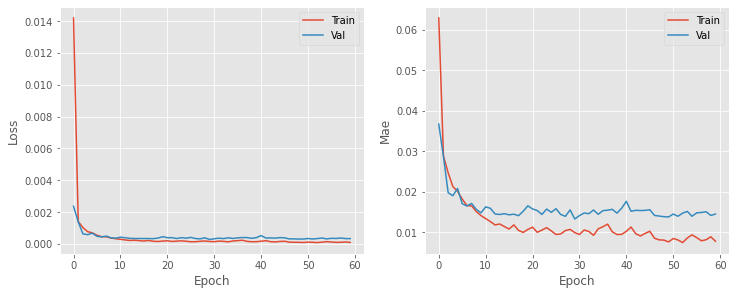

In [ ]:
plot_metrics(history).show()

In [ ]:
show_model_performances(model,[train_generator,validation_generator,test_generator])

Train set
	Mean Squared Error : 9.208291885443032e-05
	Mean Absolute Error : 0.007736914325505495
	Average euclidean distance
		1.74 voxels
		1.71 millimeters
	Single point average euclidean distance
		Point 0 : 1.67 millimeters
		Point 1 : 1.64 millimeters
		Point 2 : 1.81 millimeters
		Point 3 : 1.73 millimeters

Validation set
	Mean Squared Error : 0.0003364545991644263
	Mean Absolute Error : 0.014450707472860813
	Average euclidean distance
		3.32 voxels
		3.25 millimeters
	Single point average euclidean distance
		Point 0 : 3.31 millimeters
		Point 1 : 3.27 millimeters
		Point 2 : 3.17 millimeters
		Point 3 : 3.23 millimeters

Test set
	Mean Squared Error : 0.0003358792164362967
	Mean Absolute Error : 0.01461049821227789
	Average euclidean distance
		3.39 voxels
		3.30 millimeters
	Single point average euclidean distance
		Point 0 : 2.90 millimeters
		Point 1 : 3.25 millimeters
		Point 2 : 3.41 millimeters
		Point 3 : 3.62 millimeters



In [ ]:
model.save(BASE_DIR + "scratch_tanh.h5")

## Hyperparameters tuning

### Tune the convolutional base

Tuning of:


*   Kernels size
*   Activation function of the convolutional layers
*   Pooling type



In [ ]:
def build_model(hp):

  model = tf.keras.Sequential() # sequential API

  model.add(keras.Input(shape=(128,128,64,1)))

  kernel_size_0 = hp.Int("kernel_size_0", min_value=1, max_value=5, step=1)
  kernel_size_1 = hp.Int("kernel_size_1", min_value=1, max_value=5, step=1)
  kernel_size_2 = hp.Int("kernel_size_2", min_value=1, max_value=3, step=1)
  kernel_size_3 = hp.Int("kernel_size_3", min_value=1, max_value=3, step=1)

  activation = hp.Choice("conv_activation", ["relu","elu","LeakyReLU","PReLU","tanh"])

  pooling_type = hp.Choice("pooling_type",["max","avg"])

  if pooling_type == "max":
    pooling_layer = layers.MaxPooling3D(2)
  else:
    pooling_layer = layers.AveragePooling3D(2)

  model.add(layers.Conv3D(filters = 64, kernel_size = kernel_size_0, activation = activation))
  model.add(pooling_layer)

  model.add(layers.Conv3D(filters = 64,kernel_size = kernel_size_1, activation = activation))
  model.add(pooling_layer)

  model.add(layers.Conv3D(filters = 128,kernel_size = kernel_size_2,activation = activation))
  model.add(pooling_layer)

  model.add(layers.Conv3D(filters = 128,kernel_size = kernel_size_3,activation = activation,))
  model.add(pooling_layer)

  model.add(Flatten())

  model.add(layers.Dense(128, activation="relu"))

  model.add(layers.Dense(12, activation="linear"))

  model.compile(optimizer = "adam",loss = "mse",metrics = ["mae"])

  return model

In [ ]:
hp = kt.HyperParameters()
tuner = kt.BayesianOptimization(
    hypermodel = build_model,
    objective = "val_mae",
    max_trials = 20, # try 20 different model configurations
    overwrite = True,
    directory = BASE_DIR,
    project_name="HPO_conv_base",
)

Perform the trainings

In [ ]:
callbacks=[keras.callbacks.EarlyStopping(monitor='val_mae',patience=2)]
tuner.search(train_generator, epochs=10, validation_data = validation_generator,callbacks = callbacks)

Trial 18 Complete [00h 04m 27s]
val_mae: 0.020537206903100014

Best val_mae So Far: 0.018113240599632263
Total elapsed time: 03h 02m 40s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
1                 |5                 |kernel_size_0
5                 |1                 |kernel_size_1
1                 |3                 |kernel_size_2
1                 |1                 |kernel_size_3
relu              |relu              |conv_activation
max               |max               |pooling_type

Epoch 1/10
183/183 [==============================] - 153s 833ms/step - loss: 0.0880 - mae: 0.0934 - val_loss: 0.0030 - val_mae: 0.0419
Epoch 2/10
183/183 [==============================] - 152s 832ms/step - loss: 0.0031 - mae: 0.0424 - val_loss: 0.0028 - val_mae: 0.0403
Epoch 3/10
183/183 [==============================] - 152s 832ms/step - loss: 0.0020 - mae: 0.0336 - val_loss: 0.0014 - val_mae: 0.0285
Epoch 4/10
183/183 [==============================] - 152s 8

Show the final results

In [ ]:
tuner.results_summary()

Results summary
Results in /gdrive/MyDrive/HH and Guys - Voxel coords/HPO_conv_base
Showing 10 best trials
Trial summary
Hyperparameters:
kernel_size_0: 5
kernel_size_1: 1
kernel_size_2: 1
kernel_size_3: 3
conv_activation: relu
pooling_type: max
Score: 0.018471213057637215
Trial summary
Hyperparameters:
kernel_size_0: 1
kernel_size_1: 3
kernel_size_2: 1
kernel_size_3: 2
conv_activation: relu
pooling_type: max
Score: 0.02040926367044449
Trial summary
Hyperparameters:
kernel_size_0: 1
kernel_size_1: 5
kernel_size_2: 1
kernel_size_3: 3
conv_activation: relu
pooling_type: max
Score: 0.02067016065120697
Trial summary
Hyperparameters:
kernel_size_0: 5
kernel_size_1: 1
kernel_size_2: 3
kernel_size_3: 3
conv_activation: relu
pooling_type: max
Score: 0.020706430077552795
Trial summary
Hyperparameters:
kernel_size_0: 4
kernel_size_1: 1
kernel_size_2: 1
kernel_size_3: 1
conv_activation: relu
pooling_type: max
Score: 0.020960047841072083
Trial summary
Hyperparameters:
kernel_size_0: 1
kernel_size_

Train the best architecture for 60 epochs

In [ ]:
def cnn_tuned_conv_base():

    inputs = keras.Input((128, 128, 64, 1))

    x = layers.Conv3D(filters=64, kernel_size=5, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=64, kernel_size=1, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=1, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units=128, activation="relu")(x)

    outputs = layers.Dense(units=12, activation="linear")(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss="mse", metrics=["mae"], optimizer="adam")

    return model

In [ ]:
model = cnn_tuned_conv_base()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 124, 124, 60, 64)  8064      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 62, 62, 30, 64)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 62, 62, 30, 64)    4160      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 31, 31, 15, 64)   0         
 3D)                                                             
                                                           

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=60)

Epoch 1/60
183/183 [==============================] - 46s 248ms/step - loss: 0.0184 - mae: 0.0593 - val_loss: 0.0022 - val_mae: 0.0362
Epoch 2/60
183/183 [==============================] - 45s 247ms/step - loss: 0.0018 - mae: 0.0331 - val_loss: 0.0014 - val_mae: 0.0299
Epoch 3/60
183/183 [==============================] - 45s 247ms/step - loss: 0.0012 - mae: 0.0271 - val_loss: 7.5381e-04 - val_mae: 0.0211
Epoch 4/60
183/183 [==============================] - 45s 247ms/step - loss: 0.0010 - mae: 0.0250 - val_loss: 6.4570e-04 - val_mae: 0.0196
Epoch 5/60
183/183 [==============================] - 45s 247ms/step - loss: 9.5425e-04 - mae: 0.0235 - val_loss: 7.8047e-04 - val_mae: 0.0218
Epoch 6/60
183/183 [==============================] - 45s 246ms/step - loss: 7.1447e-04 - mae: 0.0208 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 7/60
183/183 [==============================] - 45s 247ms/step - loss: 7.1107e-04 - mae: 0.0207 - val_loss: 6.8306e-04 - val_mae: 0.0200
Epoch 8/60
183/183 [=======

In [ ]:
plot_metrics(history).show()

In [ ]:
show_model_performances(model,[train_generator,validation_generator,test_generator])

### Tune the convolutional base (cont.)

Tuning of:

*   Activation function of the convolutional layers: ReLU and GeLU
*   Number of filters



In [ ]:
def build_model(hp):

  model = tf.keras.Sequential() # sequential API

  model.add(keras.Input(shape=(128,128,64,1)))

  filters_0 = hp.Choice("filters_0",[32,64,96,128])
  filters_1 = hp.Choice("filters_1",[32,64,96,128])
  filters_2 = hp.Choice("filters_2",[128,192,256])
  filters_3 = hp.Choice("filters_3",[128,192,256])

  activation = hp.Choice("conv_activation", ["relu","gelu","elu"])

  model.add(layers.Conv3D(filters = filters_0, kernel_size = 3, activation = activation))
  model.add(layers.MaxPool3D(pool_size=2))

  model.add(layers.Conv3D(filters = filters_1,kernel_size = 3, activation = activation))
  model.add(layers.MaxPool3D(pool_size=2))

  model.add(layers.Conv3D(filters = filters_2,kernel_size = 3, activation = activation))
  model.add(layers.MaxPool3D(pool_size=2))

  model.add(layers.Conv3D(filters = filters_3,kernel_size = 3, activation = activation))
  model.add(layers.MaxPool3D(pool_size=2))

  model.add(Flatten())

  model.add(layers.Dense(128, activation="relu"))

  model.add(layers.Dense(12, activation="linear"))

  model.compile(optimizer = "adam",loss = "mse",metrics = ["mae"])

  return model

In [ ]:
hp = kt.HyperParameters()
tuner = kt.BayesianOptimization(
    hypermodel = build_model,
    objective = "val_mae",
    max_trials = 20, # try 20 different model configurations
    overwrite = True,
    directory = BASE_DIR,
    project_name="HPO_conv_base_new",
)

Perform the trainings

In [ ]:
callbacks=[keras.callbacks.EarlyStopping(monitor='val_mae',patience=2)]
tuner.search(train_generator, epochs=10, validation_data = validation_generator,callbacks = callbacks)

Trial 20 Complete [00h 13m 08s]
val_mae: 0.013904261402785778

Best val_mae So Far: 0.013904261402785778
Total elapsed time: 03h 04m 02s
INFO:tensorflow:Oracle triggered exit


Show the final results

In [ ]:
tuner.results_summary()

Results summary
Results in /gdrive/MyDrive/HH and Guys - Voxel coords/HPO_conv_base_new
Showing 10 best trials
Trial summary
Hyperparameters:
filters_0: 128
filters_1: 32
filters_2: 128
filters_3: 128
conv_activation: gelu
Score: 0.013904261402785778
Trial summary
Hyperparameters:
filters_0: 128
filters_1: 32
filters_2: 128
filters_3: 128
conv_activation: gelu
Score: 0.014181774109601974
Trial summary
Hyperparameters:
filters_0: 128
filters_1: 32
filters_2: 128
filters_3: 128
conv_activation: gelu
Score: 0.014773188158869743
Trial summary
Hyperparameters:
filters_0: 32
filters_1: 32
filters_2: 128
filters_3: 256
conv_activation: gelu
Score: 0.015223493799567223
Trial summary
Hyperparameters:
filters_0: 128
filters_1: 32
filters_2: 128
filters_3: 128
conv_activation: gelu
Score: 0.0176566019654274
Trial summary
Hyperparameters:
filters_0: 96
filters_1: 32
filters_2: 128
filters_3: 256
conv_activation: gelu
Score: 0.01989864371716976
Trial summary
Hyperparameters:
filters_0: 32
filters_1

Train the best architecture for 60 epochs

In [ ]:
def cnn_tuned_conv_base():

    inputs = keras.Input((128, 128, 64, 1))

    x = layers.Conv3D(filters=128, kernel_size=3, activation="gelu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="gelu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="gelu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="gelu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units=128, activation="relu")(x)

    outputs = layers.Dense(units=12, activation="linear")(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss="mse", metrics=["mae"], optimizer="adam")

    return model

In [ ]:
model = cnn_tuned_conv_base()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_8 (Conv3D)           (None, 126, 126, 62, 128  3584      
                             )                                   
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 63, 63, 31, 128)  0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 61, 61, 29, 32)    110624    
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 30, 30, 14, 32)   0         
 3D)                                                       

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=60)

Epoch 1/60
183/183 [==============================] - 79s 425ms/step - loss: 0.0085 - mae: 0.0611 - val_loss: 0.0013 - val_mae: 0.0278
Epoch 2/60
183/183 [==============================] - 78s 429ms/step - loss: 0.0013 - mae: 0.0273 - val_loss: 9.7854e-04 - val_mae: 0.0243
Epoch 3/60
183/183 [==============================] - 79s 429ms/step - loss: 8.2408e-04 - mae: 0.0220 - val_loss: 6.6625e-04 - val_mae: 0.0201
Epoch 4/60
183/183 [==============================] - 78s 429ms/step - loss: 6.7547e-04 - mae: 0.0200 - val_loss: 6.9355e-04 - val_mae: 0.0205
Epoch 5/60
183/183 [==============================] - 79s 429ms/step - loss: 4.9447e-04 - mae: 0.0172 - val_loss: 4.4312e-04 - val_mae: 0.0165
Epoch 6/60
183/183 [==============================] - 78s 429ms/step - loss: 4.1907e-04 - mae: 0.0160 - val_loss: 4.4995e-04 - val_mae: 0.0167
Epoch 7/60
183/183 [==============================] - 79s 429ms/step - loss: 3.0040e-04 - mae: 0.0136 - val_loss: 4.9363e-04 - val_mae: 0.0173
Epoch 8/60


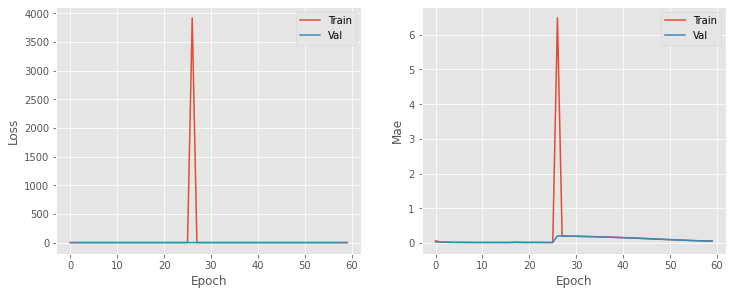

In [ ]:
plot_metrics(history).show()

In [ ]:
show_model_performances(model,[train_generator,validation_generator,test_generator])

Train set
	Mean Squared Error : 0.004981630016118288
	Mean Absolute Error : 0.05246248468756676
	Average euclidean distance
		13.38 voxels
		12.72 millimeters
	Single point average euclidean distance
		Point 0 : 9.77 millimeters
		Point 1 : 10.77 millimeters
		Point 2 : 16.69 millimeters
		Point 3 : 13.67 millimeters

Validation set
	Mean Squared Error : 0.004889897536486387
	Mean Absolute Error : 0.051750194281339645
	Average euclidean distance
		13.09 voxels
		12.43 millimeters
	Single point average euclidean distance
		Point 0 : 8.76 millimeters
		Point 1 : 10.79 millimeters
		Point 2 : 16.81 millimeters
		Point 3 : 13.34 millimeters

Test set
	Mean Squared Error : 0.005925016012042761
	Mean Absolute Error : 0.05763476714491844
	Average euclidean distance
		14.99 voxels
		14.20 millimeters
	Single point average euclidean distance
		Point 0 : 10.41 millimeters
		Point 1 : 12.45 millimeters
		Point 2 : 18.59 millimeters
		Point 3 : 15.34 millimeters



### Tune the fully connected head

In [ ]:
hp = kt.HyperParameters()

In [ ]:
def build_model(hp):

  # re-instantiate from scratch the base model at each trial
  inputs = keras.Input((128, 128, 64, 1))
  x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  outputs = layers.Flatten()(x)
  base_model = keras.Model(inputs, outputs)

  # conversion from funtional API to sequential API
  model = keras.Sequential(base_model)

  # Dropout layer
  model.add(layers.Dropout(rate=hp.Choice("dropout_rate", [0.0,0.25,0.5,0.8])))

  activation = hp.Choice("activation", ["relu","gelu","elu","tanh"])

  # FC layers
  for i in range(hp.Int("num_layers", 1, 3)):

    model.add(
        layers.Dense(
            units=hp.Choice(f"units_{i}",[128,256,512,1024,2048]),
            activation=activation,
        )
    )

  model.add(layers.Dense(12, activation="linear"))

  # Learning rate
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

  model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
    loss = "mse",
    metrics = ["mae"]
  )

  return model

Tuner class to run the search

In [ ]:
tuner = kt.BayesianOptimization(
    hypermodel = build_model,
    objective = "val_mae",
    max_trials = 20, # try 20 different model configurations
    overwrite = True,
    directory = BASE_DIR,
    project_name="HPO_scratch",
)

Perform the trainings

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_mae",patience=2)
tuner.search(train_generator, epochs=10, validation_data = validation_generator)

Trial 20 Complete [00h 05m 30s]
val_mae: 0.016720522195100784

Best val_mae So Far: 0.015754051506519318
Total elapsed time: 01h 51m 48s
INFO:tensorflow:Oracle triggered exit


Show the final results

In [ ]:
tuner.results_summary()

Results summary
Results in /gdrive/MyDrive/HH and Guys - Voxel coords/HPO_scratch
Showing 10 best trials
Trial summary
Hyperparameters:
dropout_rate: 0.0
activation: relu
num_layers: 3
units_0: 2048
lr: 0.0001
units_1: 128
units_2: 128
Score: 0.015754051506519318
Trial summary
Hyperparameters:
dropout_rate: 0.0
activation: tanh
num_layers: 3
units_0: 2048
lr: 0.0001
units_1: 128
units_2: 2048
Score: 0.015846630558371544
Trial summary
Hyperparameters:
dropout_rate: 0.0
activation: relu
num_layers: 3
units_0: 128
lr: 0.0001
units_1: 128
units_2: 2048
Score: 0.01589816063642502
Trial summary
Hyperparameters:
dropout_rate: 0.0
activation: relu
num_layers: 1
units_0: 2048
lr: 0.0001
units_1: 128
units_2: 2048
Score: 0.016016321256756783
Trial summary
Hyperparameters:
dropout_rate: 0.0
activation: tanh
num_layers: 1
units_0: 2048
lr: 0.0001
units_1: 2048
units_2: 2048
Score: 0.01603720150887966
Trial summary
Hyperparameters:
dropout_rate: 0.0
activation: relu
num_layers: 1
units_0: 2048
lr: 

Train the best model obtained in the HPO process
```
Hyperparameters:
dropout_rate: 0.0
activation: relu
num_layers: 3
units_0: 2048
lr: 0.0001
units_1: 128
units_2: 128
Score: 0.015754051506519318
```



In [ ]:
inputs = keras.Input((128, 128, 64, 1))

x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPool3D(pool_size=2)(x)

x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPool3D(pool_size=2)(x)

x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPool3D(pool_size=2)(x)

x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPool3D(pool_size=2)(x)

x = layers.Flatten()(x)

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

outputs = layers.Dense(12, activation="linear")(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001),loss = "mse",metrics = ["mae"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 30, 14, 64)   0         
 3D)                                                             
                                                             

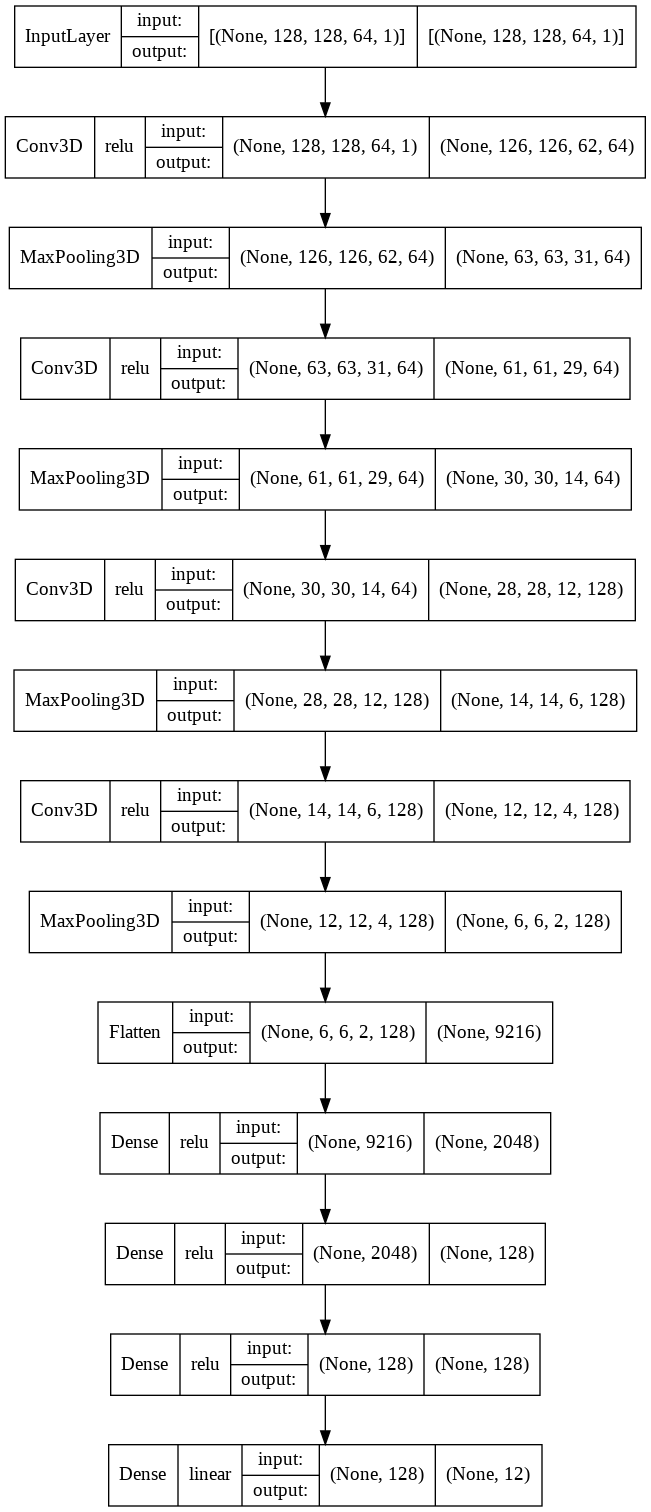

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_activations=True, show_layer_names=False)

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=60)

Epoch 1/60
183/183 [==============================] - 34s 180ms/step - loss: 0.0047 - mae: 0.0477 - val_loss: 0.0017 - val_mae: 0.0315
Epoch 2/60
183/183 [==============================] - 33s 178ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 3/60
183/183 [==============================] - 32s 176ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 7.3365e-04 - val_mae: 0.0206
Epoch 4/60
183/183 [==============================] - 32s 177ms/step - loss: 5.9436e-04 - mae: 0.0189 - val_loss: 5.1256e-04 - val_mae: 0.0176
Epoch 5/60
183/183 [==============================] - 32s 177ms/step - loss: 5.3109e-04 - mae: 0.0177 - val_loss: 5.8217e-04 - val_mae: 0.0185
Epoch 6/60
183/183 [==============================] - 33s 178ms/step - loss: 5.2090e-04 - mae: 0.0175 - val_loss: 4.9979e-04 - val_mae: 0.0176
Epoch 7/60
183/183 [==============================] - 32s 176ms/step - loss: 4.0230e-04 - mae: 0.0157 - val_loss: 4.4067e-04 - val_mae: 0.0167
Epoch 8/60
183/183 

In [ ]:
model.save(BASE_DIR + "scratch_HPO.h5")

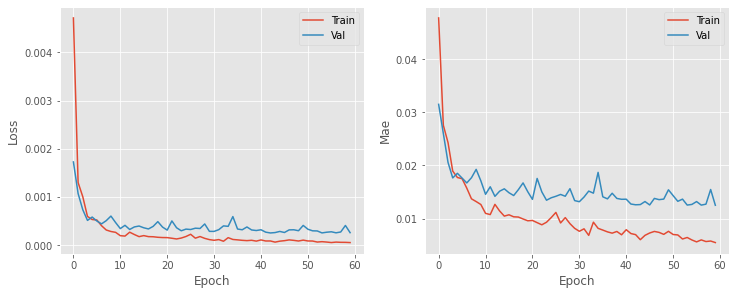

In [ ]:
plot_metrics(history).show()

In [ ]:
show_model_performances(model,[train_generator,validation_generator,test_generator])

Train set
	Mean Squared Error : 3.632651350926608e-05
	Mean Absolute Error : 0.0046813227236270905
	Average euclidean distance
		1.07 voxels
		1.05 millimeters
	Single point average euclidean distance
		Point 0 : 0.83 millimeters
		Point 1 : 0.87 millimeters
		Point 2 : 1.18 millimeters
		Point 3 : 1.32 millimeters

Validation set
	Mean Squared Error : 0.0002578748681116849
	Mean Absolute Error : 0.012490792199969292
	Average euclidean distance
		2.89 voxels
		2.82 millimeters
	Single point average euclidean distance
		Point 0 : 2.51 millimeters
		Point 1 : 2.91 millimeters
		Point 2 : 2.73 millimeters
		Point 3 : 3.11 millimeters

Test set
	Mean Squared Error : 0.00024124608899001032
	Mean Absolute Error : 0.01217034924775362
	Average euclidean distance
		2.80 voxels
		2.73 millimeters
	Single point average euclidean distance
		Point 0 : 2.20 millimeters
		Point 1 : 2.73 millimeters
		Point 2 : 2.97 millimeters
		Point 3 : 3.02 millimeters



In [ ]:
model = keras.models.load_model(BASE_DIR + "scratch_HPO.h5")

In [ ]:
create_obj_files("Predictions_test_scratchHPO",model,test_generator)

# Experiments - Data augmentation

## Models & Validation and Test set

The best models obtained so far

In [ ]:
def hyper_scratch():

  inputs = keras.Input((128, 128, 64, 1))

  x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
  x = layers.MaxPool3D(pool_size=2)(x)

  x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPool3D(pool_size=2)(x)

  x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPool3D(pool_size=2)(x)

  x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPool3D(pool_size=2)(x)

  x = layers.Flatten()(x)

  x = layers.Dense(2048, activation="relu")(x)
  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dense(128, activation="relu")(x)

  outputs = layers.Dense(12, activation="linear")(x)

  model = keras.Model(inputs, outputs)

  model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001),loss = "mse",metrics = ["mae"])

  return model

In [ ]:
def hyper_densenet():

  densenet_3d = DenseNet121(
    input_shape = (128,128,64,1),
    include_top = False,
    base_channel = 16
  )

  inputs = keras.Input(shape=(128,128,64,1))
  x = densenet_3d(inputs)
  x = layers.Flatten()(x)
  x = layers.Dense(2048, activation='relu')(x)
  outputs = layers.Dense(12, activation="linear")(x)

  model = keras.Model(inputs, outputs)

  model.compile(loss="mse", metrics=["mae"], optimizer = keras.optimizers.Adam(learning_rate=0.0001))

  return model

Validation and test set

In [ ]:
validation_volumes, validation_targets, validation_filenames = generate_dataset(BASE_DIR + "Validation/")
test_volumes, test_targets, test_filenames = generate_dataset(BASE_DIR + "Test/")
validation_generator = Generator(validation_volumes,validation_targets,validation_filenames,"Validation")
test_generator = Generator(test_volumes,test_targets,test_filenames,"Test")

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## Utility functions for roto-translations

Utility functions to perform roto-translations on the 3 axes and on general axis (https://en.wikipedia.org/wiki/Rotation_matrix#Rotation_matrix_from_axis_and_angle).

In [ ]:
def create_augmentation_affine_matrix(rotation_axis, rotation_angle, tx, ty, tz, general_axis=[]):
  '''
  Return a 4x4 matrix related to the specified rotation and translation

  rotation_axis [string] : the axis for the rotation
  rotation_angle [float] : the angle for the rotation, expressed in degrees
  tx [int] : number of voxels for the translation on the x-axis
  ty [int] : number of voxels for the translation on the y-axis
  tz [int] : number of voxels for the translation on the z-axis
  '''

  augmentation_affine_matrix = np.eye(4)

  rotation_angle = math.radians(rotation_angle) # from degrees to radians
  rotation_angle_cosine = math.cos(rotation_angle)
  rotation_angle_sin = math.sin(rotation_angle)

  # translation
  augmentation_affine_matrix[0,3] = tx
  augmentation_affine_matrix[1,3] = ty
  augmentation_affine_matrix[2,3] = tz

  # rotation
  if rotation_axis == "x":
    augmentation_affine_matrix[1,1] = rotation_angle_cosine
    augmentation_affine_matrix[2,2] = rotation_angle_cosine
    augmentation_affine_matrix[1,2] = -rotation_angle_sin
    augmentation_affine_matrix[2,1] = rotation_angle_sin

  elif rotation_axis == "y":
    augmentation_affine_matrix[0,0] = rotation_angle_cosine
    augmentation_affine_matrix[2,2] = rotation_angle_cosine
    augmentation_affine_matrix[0,2] = rotation_angle_sin
    augmentation_affine_matrix[2,0] = -rotation_angle_sin

  elif rotation_axis == "z":
    augmentation_affine_matrix[0,0] = rotation_angle_cosine
    augmentation_affine_matrix[1,1] = rotation_angle_cosine
    augmentation_affine_matrix[0,1] = -rotation_angle_sin
    augmentation_affine_matrix[1,0] = rotation_angle_sin

  # rotation on general axis
  else:
    # get unit vector
    general_axis =  general_axis/ np.linalg.norm(general_axis)

    augmentation_affine_matrix[0,0] = rotation_angle_cosine + (pow(general_axis[0],2)*(1-rotation_angle_cosine))
    augmentation_affine_matrix[0,1] = (general_axis[0]*general_axis[1]*(1-rotation_angle_cosine)) - (general_axis[2]*rotation_angle_sin)
    augmentation_affine_matrix[0,3] = (general_axis[0]*general_axis[2]*(1-rotation_angle_cosine)) + (general_axis[1]*rotation_angle_sin)

    augmentation_affine_matrix[1,0] = (general_axis[1]*general_axis[0]*(1-rotation_angle_cosine)) + (general_axis[2]*rotation_angle_sin)
    augmentation_affine_matrix[1,1] = rotation_angle_cosine + (pow(general_axis[1],2)*(1-rotation_angle_cosine))
    augmentation_affine_matrix[1,2] = (general_axis[1]*general_axis[2]*(1-rotation_angle_cosine)) - (general_axis[0]*rotation_angle_sin)

    augmentation_affine_matrix[2,0] = (general_axis[2]*general_axis[0]*(1-rotation_angle_cosine)) - (general_axis[1]*rotation_angle_sin)
    augmentation_affine_matrix[2,1] = (general_axis[2]*general_axis[1]*(1-rotation_angle_cosine)) + (general_axis[0]*rotation_angle_sin)
    augmentation_affine_matrix[2,2] = rotation_angle_cosine + (pow(general_axis[2],2)*(1-rotation_angle_cosine))

  return augmentation_affine_matrix

In [ ]:
def augment_coordinates(volume_name, augmentation_affine_matrix, out_file,T2=False):

  if T2 is True:
    annotation_path = BASE_DIR + "Training_T2/Annotations/"+volume_name[:-7]+"_annot.json"
    volume_path = BASE_DIR + "Training_T2/Volumes/"+volume_name
  else:
    annotation_path = BASE_DIR + "Training/Annotations/"+volume_name[:-7]+"_annot.json"
    volume_path = BASE_DIR + "Training/Volumes/"+volume_name

  with open(annotation_path, "r") as f:

    json_dict = json.load(f)
    points = get_coordinates_list(annotation_path)
    for i,point in zip(range(4),points):

      # from world to voxel coordinates
      voxel_coords = get_voxel_coordinates(volume_path,point)
      voxel_coords = np.append(voxel_coords,1)

      # augmentation
      augmented_voxel_coords = augmentation_affine_matrix.dot(voxel_coords)
      augmented_voxel_coords = augmented_voxel_coords[:3] # from homogeneous to euclidean coordinates

      # from voxel to world coordinates
      augmented_coords = apply_affine(world2vox_affine,augmented_voxel_coords)

      json_dict["markups"][0]["controlPoints"][i]["position"][0] = -augmented_coords[0]
      json_dict["markups"][0]["controlPoints"][i]["position"][1] = -augmented_coords[1]
      json_dict["markups"][0]["controlPoints"][i]["position"][2] = augmented_coords[2]

  with open(out_file, "w") as f:
    json.dump(json_dict, f, indent=4)

Check: roto-translation on y-axis

In [ ]:
SAMPLE_VOLUME_NAME = "IXI015-HH-1258-T1.nii.gz"
SAMPLE_VOLUME_PATH = BASE_DIR + "Training/Volumes/IXI015-HH-1258-T1.nii.gz"
SAMPLE_VOLUME_ANNOTATION_PATH = BASE_DIR + "Training/Annotations/IXI015-HH-1258-T1_annot.json"

In [ ]:
volume = read_nifti_file(SAMPLE_VOLUME)
world2vox_affine = nib.load(SAMPLE_VOLUME).affine

In [ ]:
augmentation_affine_matrix = create_augmentation_affine_matrix("y",15,10,7,20)
augmentation_affine_matrix_inverse = np.linalg.inv(augmentation_affine_matrix)
augmented_volume = ndimage.affine_transform(volume,augmentation_affine_matrix_inverse,output_shape=volume.shape)
nib.save(nib.Nifti1Image(augmented_volume, world2vox_affine),"augmented_volume_rotation_translation.nii.gz")
augment_coordinates(SAMPLE_VOLUME_NAME,augmentation_affine_matrix,"augmented_volume_rotation_translation_annotation.json")

## Augmentation 1

### Create an augmented training set

In [ ]:
os.mkdir(BASE_DIR + "AugmentedTraining")
os.mkdir(BASE_DIR + "AugmentedTraining/Volumes")
os.mkdir(BASE_DIR + "AugmentedTraining/Annotations")

Copy the original training set

In [ ]:
filenames_list = os.listdir(BASE_DIR + "Training/Volumes")

for file_name in filenames_list:
  volume_path = BASE_DIR + "Training/Volumes/"+file_name
  annotation_path = BASE_DIR + "Training/Annotations/"+file_name[:-7]+"_annot.json"
  shutil.copy(volume_path,BASE_DIR + "AugmentedTraining/Volumes/")
  shutil.copy(annotation_path,BASE_DIR + "AugmentedTraining/Annotations/")

In [ ]:
len(os.listdir(BASE_DIR + "AugmentedTraining/Volumes"))

366

And create new augmented volumes, with the relative modified annotations

In [ ]:
volumes_names = os.listdir(BASE_DIR + "Training/Volumes")

rotation_angles = np.arange(-20,21) # expressed in degrees
translation_values = np.arange(-10,11) # expressed in voxels

rotation_angles_indexes = np.arange(40)
tx_indexes = np.arange(20)
ty_indexes = np.arange(20)
tz_indexes = np.arange(20)

for volume_name,i in zip(volumes_names,tqdm(range(len(volumes_names)))):

  volume = read_nifti_file(BASE_DIR + "Training/Volumes/" + volume_name)
  world2vox_affine = nib.load(BASE_DIR + "Training/Volumes/" + volume_name).affine
  annotation_path = BASE_DIR + "Training/Annotations/" + volume_name[:-7] + "_annot.json"

  for axis in ["x","y","z"]:

    np.random.shuffle(rotation_angles_indexes)
    np.random.shuffle(tx_indexes)
    np.random.shuffle(ty_indexes)
    np.random.shuffle(tz_indexes)

    for i in range(1):

      rotation_angle = rotation_angles[rotation_angles_indexes[i]]
      tx = translation_values[tx_indexes[i]]
      ty = translation_values[ty_indexes[i]]
      tz = translation_values[tz_indexes[i]]

      augmentation_affine_matrix = create_augmentation_affine_matrix(axis,rotation_angle,tx,ty,tz)

      augmentation_affine_matrix_inverse = np.linalg.inv(augmentation_affine_matrix) # invert the matrix to use the ndimage.affine_transform method

      # apply the transformation to the original volume
      augmented_volume = ndimage.affine_transform(volume,augmentation_affine_matrix_inverse,output_shape=volume.shape)

      # save the augmented volume into a Nifti file
      augmented_volume_name = volume_name[:-7] + "_" + axis + "_" + str(rotation_angle) + "_" + str(tx) + "_" + str(ty) + "_" + str(tz) + ".nii.gz"
      nib.save(nib.Nifti1Image(augmented_volume, world2vox_affine),BASE_DIR + "AugmentedTraining/Volumes/"+augmented_volume_name)

      # modify the target coordinates
      augmented_annotation_name = augmented_volume_name[:-7] + "_annot.json"
      augment_coordinates(volume_name, augmentation_affine_matrix,BASE_DIR + "AugmentedTraining/Annotations/"+augmented_annotation_name)


100%|█████████▉| 365/366 [2:13:45<00:21, 21.99s/it]


In [ ]:
print(len(os.listdir(BASE_DIR + "AugmentedTraining/Volumes")))
print(len(os.listdir(BASE_DIR + "AugmentedTraining/Annotations")))

1464
1464


### Preprocess the augmented training set and save it into a H5 file on disk

Since the pre-processing is computationally expensive and time-consuming, I performed it only once and saved the generated dataset on a H5 file on disk.

First part ...

In [ ]:
train_volumes_chunk_1, train_targets_chunk_1, train_filenames_chunk_1 = generate_dataset(BASE_DIR + "AugmentedTraining/",start_idx=0,end_idx=732)

with h5py.File(BASE_DIR + "preprocessed_augmentedtrain1.h5", 'w') as hf:
  hf.create_dataset("volumes", data=train_volumes_chunk_1,maxshape=(None,128,128,64,1))
  hf.create_dataset("targets", data=train_targets_chunk_1,maxshape=(None,12))
  hf.create_dataset("filenames", data=train_filenames_chunk_1,maxshape=(None,))

  0%|          | 0/732 [00:00<?, ?it/s]

... and second part

In [ ]:
train_volumes_chunk_2, train_targets_chunk_2, train_filenames_chunk_2 = generate_dataset(BASE_DIR + "AugmentedTraining/",start_idx=732,end_idx=1464)

# append the second chunk of volumes to the h5 file
with h5py.File(BASE_DIR + "preprocessed_augmentedtrain1.h5", 'a') as hf:
  hf["volumes"].resize((len(hf["volumes"]) + len(train_volumes_chunk_2)), axis = 0)
  hf["volumes"][-len(train_volumes_chunk_2):] = train_volumes_chunk_2

  hf["targets"].resize((len(hf["targets"]) + len(train_targets_chunk_2)), axis = 0)
  hf["targets"][-len(train_targets_chunk_2):] = train_targets_chunk_2

  hf["filenames"].resize((len(hf["filenames"]) + len(train_filenames_chunk_2)), axis = 0)
  hf["filenames"][-len(train_filenames_chunk_2):] = train_filenames_chunk_2

  0%|          | 0/732 [00:00<?, ?it/s]

### Experiments

In [ ]:
with h5py.File(BASE_DIR + "preprocessed_augmentedtrain1.h5", "r") as h5f:
  train_volumes = h5f["volumes"][()]
  train_targets = h5f["targets"][()]
  train_filenames = h5f["filenames"][()]

train_generator = Generator(train_volumes,train_targets,train_filenames,"Training")

In [ ]:
train_generator.filepath = [filepath.decode("utf-8") for filepath in train_generator.filepath]

In [ ]:
validation_volumes, validation_targets, validation_filenames = generate_dataset(BASE_DIR + "Validation/")
validation_generator = Generator(validation_volumes,validation_targets,validation_filenames,"Validation")

test_volumes, test_targets, test_filenames = generate_dataset(BASE_DIR + "Test/")
test_generator = Generator(test_volumes,test_targets,test_filenames,"Test")

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

#### Scratch

In [ ]:
model = hyper_scratch()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 30, 30, 14, 64)   0         
 3D)                                                             
                                                           

In [ ]:
history = model.fit(train_generator,validation_data= validation_generator,epochs=60)

Epoch 1/60
732/732 [==============================] - 124s 168ms/step - loss: 0.0070 - mae: 0.0569 - val_loss: 0.0020 - val_mae: 0.0374
Epoch 2/60
732/732 [==============================] - 122s 167ms/step - loss: 0.0018 - mae: 0.0316 - val_loss: 0.0018 - val_mae: 0.0344
Epoch 3/60
732/732 [==============================] - 122s 166ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 6.8096e-04 - val_mae: 0.0207
Epoch 4/60
732/732 [==============================] - 122s 166ms/step - loss: 9.4515e-04 - mae: 0.0235 - val_loss: 8.2359e-04 - val_mae: 0.0227
Epoch 5/60
732/732 [==============================] - 122s 166ms/step - loss: 0.0010 - mae: 0.0239 - val_loss: 4.7177e-04 - val_mae: 0.0174
Epoch 6/60
732/732 [==============================] - 122s 166ms/step - loss: 6.5314e-04 - mae: 0.0197 - val_loss: 4.1775e-04 - val_mae: 0.0160
Epoch 7/60
732/732 [==============================] - 122s 166ms/step - loss: 6.6361e-04 - mae: 0.0195 - val_loss: 4.8488e-04 - val_mae: 0.0178
Epoch 8/60
732/7

In [ ]:
model.save(BASE_DIR + "hyper_scratch_augmentation1.h5")

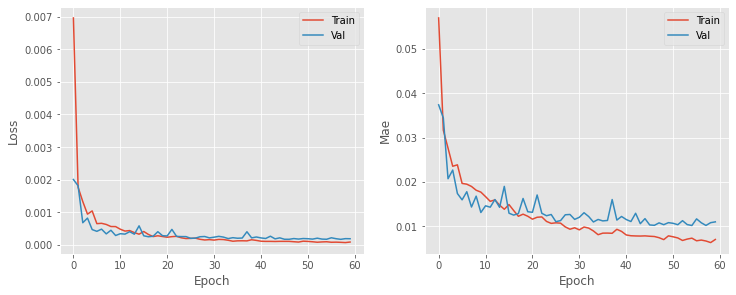

In [ ]:
plot_metrics(history).show()

In [ ]:
show_model_performances(model,[validation_generator,test_generator])

Validation set
	Mean Squared Error : 0.00019093260925728828
	Mean Absolute Error : 0.011028332635760307
	Average euclidean distance
		2.43 voxels
		2.41 millimeters
	Single point average euclidean distance
		Point 0 : 2.77 millimeters
		Point 1 : 2.48 millimeters
		Point 2 : 2.23 millimeters
		Point 3 : 2.17 millimeters

Test set
	Mean Squared Error : 0.00020749549730680883
	Mean Absolute Error : 0.011624205857515335
	Average euclidean distance
		2.56 voxels
		2.54 millimeters
	Single point average euclidean distance
		Point 0 : 2.69 millimeters
		Point 1 : 2.44 millimeters
		Point 2 : 2.60 millimeters
		Point 3 : 2.46 millimeters



In [ ]:
history = model.fit(train_generator,validation_data= validation_generator,epochs=30)

Epoch 1/30
732/732 [==============================] - 119s 163ms/step - loss: 8.0580e-05 - mae: 0.0067 - val_loss: 1.8267e-04 - val_mae: 0.0106
Epoch 2/30
732/732 [==============================] - 118s 162ms/step - loss: 7.0679e-05 - mae: 0.0064 - val_loss: 1.7782e-04 - val_mae: 0.0103
Epoch 3/30
732/732 [==============================] - 118s 162ms/step - loss: 7.9370e-05 - mae: 0.0067 - val_loss: 1.8160e-04 - val_mae: 0.0105
Epoch 4/30
732/732 [==============================] - 118s 162ms/step - loss: 8.5143e-05 - mae: 0.0069 - val_loss: 1.8492e-04 - val_mae: 0.0105
Epoch 5/30
732/732 [==============================] - 118s 161ms/step - loss: 8.6458e-05 - mae: 0.0069 - val_loss: 1.8653e-04 - val_mae: 0.0106
Epoch 6/30
732/732 [==============================] - 118s 161ms/step - loss: 7.3018e-05 - mae: 0.0064 - val_loss: 1.7595e-04 - val_mae: 0.0102
Epoch 7/30
732/732 [==============================] - 118s 162ms/step - loss: 6.9905e-05 - mae: 0.0062 - val_loss: 1.6899e-04 - val_mae:

In [ ]:
model.save(BASE_DIR + "hyper_scratch_augmentation1_90epochs.h5")

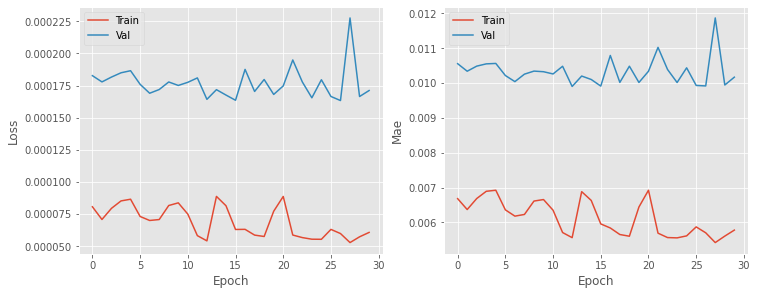

In [ ]:
plot_metrics(history).show()

In [ ]:
model = keras.models.load_model(BASE_DIR + "hyper_scratch_augmentation1_90epochs.h5")

In [ ]:
show_model_performances(model,[train_generator])

Train set
	Mean Squared Error : 5.5537442676723e-05
	Mean Absolute Error : 0.005621111951768398
	Average euclidean distance
		1.23 voxels
		1.23 millimeters
	Single point average euclidean distance
		Point 0 : 1.08 millimeters
		Point 1 : 1.17 millimeters
		Point 2 : 1.34 millimeters
		Point 3 : 1.32 millimeters



In [ ]:
show_model_performances(model,[validation_generator,test_generator])

Validation set
	Mean Squared Error : 0.00017110865155700594
	Mean Absolute Error : 0.010167163796722889
	Average euclidean distance
		2.33 voxels
		2.29 millimeters
	Single point average euclidean distance
		Point 0 : 2.42 millimeters
		Point 1 : 2.61 millimeters
		Point 2 : 2.00 millimeters
		Point 3 : 2.13 millimeters

Test set
	Mean Squared Error : 0.00016853856504894793
	Mean Absolute Error : 0.010126790963113308
	Average euclidean distance
		2.31 voxels
		2.27 millimeters
	Single point average euclidean distance
		Point 0 : 2.19 millimeters
		Point 1 : 2.10 millimeters
		Point 2 : 2.29 millimeters
		Point 3 : 2.51 millimeters



#### Results analysis

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    specs=[
           [{"type": "bar"},{"type": "bar"}],
           ],
    column_widths=[0.7, 0.7],
    subplot_titles=["MAE", "AED (mm)"]
)

fig.add_trace(go.Bar(x=["No augmentation","Augmentation"],y=[0.012,0.010],name="Scratch",text=["0.012","0.010"],marker_color='indianred'), row=1, col=1)
fig.add_trace(go.Bar(x=["No augmentation","Augmentation"],y=[0.012,0.011],name="Densenet",text=["0.012","0.011"],marker_color='lightsalmon'), row=1, col=1)

fig.add_trace(go.Bar(x=["No augmentation","Augmentation"],y=[2.82,2.29],name="scratch",text=["2.82","2.29"],marker_color='indianred'), row=1, col=2)
fig.add_trace(go.Bar(x=["No augmentation","Augmentation"],y=[2.91,2.56],name="densenet",text=["2.91","2.56"],marker_color='lightsalmon'), row=1, col=2)

fig.update_traces(textfont_size=20)
fig.update_layout(
    xaxis_tickfont_size=15,
    yaxis=dict(
        titlefont_size=15,
        tickfont_size=15,
    )
)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=4,
    specs=[
           [{"type": "bar"},{"type": "bar"},{"type": "bar"},{"type": "bar"}],
           ],
    column_widths=[0.7, 0.7,0.7, 0.7],
    subplot_titles=["AED key-point A (mm)", "AED key-point B (mm)", "AED key-point C (mm)", "AED key-point D (mm)"]
)

fig.add_trace(go.Bar(x=["No augmentation","Augmentation"],y=[2.51,2.42],name="Scratch",text=["2.51","2.42"],marker_color='indianred'), row=1, col=1)
fig.add_trace(go.Bar(x=["No augmentation","Augmentation"],y=[2.63,2.50],name="Densenet",text=["2.63","2.50"],marker_color='lightsalmon'), row=1, col=1)

fig.add_trace(go.Bar(x=["No augmentation","Augmentation"],y=[2.91,2.61],name="scratch",text=["2.91","2.61"],marker_color='indianred'), row=1, col=2)
fig.add_trace(go.Bar(x=["No augmentation","Augmentation"],y=[2.57,2.60],name="densenet",text=["2.57","2.60"],marker_color='lightsalmon'), row=1, col=2)

fig.add_trace(go.Bar(x=["No augmentation","Augmentation"],y=[2.73,2.00],name="scratch",text=["2.73","2.00"],marker_color='indianred'), row=1, col=3)
fig.add_trace(go.Bar(x=["No augmentation","Augmentation"],y=[3.08,2.43],name="densenet",text=["3.08","2.43"],marker_color='lightsalmon'), row=1, col=3)

fig.add_trace(go.Bar(x=["No augmentation","Augmentation"],y=[3.11,2.13],name="scratch",text=["3.11","2.13"],marker_color='indianred'), row=1, col=4)
fig.add_trace(go.Bar(x=["No augmentation","Augmentation"],y=[3.34,2.71],name="densenet",text=["3.34","2.71"],marker_color='lightsalmon'), row=1, col=4)

fig.update_traces(textfont_size=20)

## Augmentation 2

### Create the augmented training set 2

I needed to split the augmentation procedure in many parts, since it was time consuming and I was continually disconnected from the runtime.

#### Rotation on the 3 main axes

In [ ]:
os.mkdir(BASE_DIR + "AugmentedTraining3")
os.mkdir(BASE_DIR + "AugmentedTraining3/Volumes")
os.mkdir(BASE_DIR + "AugmentedTraining3/Annotations")

Copy the original training set

In [ ]:
filenames_list = os.listdir(BASE_DIR + "Training/Volumes")

for file_name in filenames_list:
  volume_path = BASE_DIR + "Training/Volumes/"+file_name
  annotation_path = BASE_DIR + "Training/Annotations/"+file_name[:-7]+"_annot.json"
  shutil.copy(volume_path,BASE_DIR + "AugmentedTraining3/Volumes/")
  shutil.copy(annotation_path,BASE_DIR + "AugmentedTraining3/Annotations/")

In [ ]:
len(os.listdir(BASE_DIR + "AugmentedTraining3/Volumes"))

366

In [ ]:
volumes_names = os.listdir(BASE_DIR + "Training/Volumes")

rotation_angles = np.arange(-20,21) # expressed in degrees
translation_values = np.arange(-10,11) # expressed in voxels

rotation_angles_indexes = np.arange(40)
tx_indexes = np.arange(20)
ty_indexes = np.arange(20)
tz_indexes = np.arange(20)

for volume_name,i in zip(volumes_names,tqdm(range(len(volumes_names)))):

  volume = read_nifti_file(BASE_DIR + "Training/Volumes/" + volume_name)
  world2vox_affine = nib.load(BASE_DIR + "Training/Volumes/" + volume_name).affine
  annotation_path = BASE_DIR + "Training/Annotations/" + volume_name[:-7] + "_annot.json"

  for axis in ["x","y","z"]:

    np.random.shuffle(rotation_angles_indexes)
    np.random.shuffle(tx_indexes)
    np.random.shuffle(ty_indexes)
    np.random.shuffle(tz_indexes)

    for i in range(7): # 7 roto-translation for each one of the three axes

      rotation_angle = rotation_angles[rotation_angles_indexes[i]]
      tx = translation_values[tx_indexes[i]]
      ty = translation_values[ty_indexes[i]]
      tz = translation_values[tz_indexes[i]]

      augmentation_affine_matrix = create_augmentation_affine_matrix(axis,rotation_angle,tx,ty,tz)

      augmentation_affine_matrix_inverse = np.linalg.inv(augmentation_affine_matrix) # invert the matrix to use the ndimage.affine_transform method

      # apply the transformation to the original volume
      augmented_volume = ndimage.affine_transform(volume,augmentation_affine_matrix_inverse,output_shape=volume.shape)

      # save the augmented volume into a Nifti file
      augmented_volume_name = volume_name[:-7] + "_" + axis + "_" + str(rotation_angle) + "_" + str(tx) + "_" + str(ty) + "_" + str(tz) + ".nii.gz"
      nib.save(nib.Nifti1Image(augmented_volume, world2vox_affine),BASE_DIR + "AugmentedTraining3/Volumes/"+augmented_volume_name)

      # modify the target coordinates
      augmented_annotation_name = augmented_volume_name[:-7] + "_annot.json"
      augment_coordinates(volume_name, augmentation_affine_matrix,BASE_DIR + "AugmentedTraining3/Annotations/"+augmented_annotation_name)


In [ ]:
print(len(os.listdir(BASE_DIR+"AugmentedTraining3/Volumes")))
print(len(os.listdir(BASE_DIR+"AugmentedTraining3/Annotations")))

8428
8428


In [ ]:
train_volumes_chunk, train_targets_chunk, train_filenames_chunk = generate_dataset(BASE_DIR + "AugmentedTraining3/",start_idx=0,end_idx=526)

with h5py.File(BASE_DIR + "preprocessed_augmentedtrain3.h5", 'w') as hf:
  hf.create_dataset("volumes", data=train_volumes_chunk,maxshape=(None,128,128,64,1))
  hf.create_dataset("targets", data=train_targets_chunk,maxshape=(None,12))
  hf.create_dataset("filenames", data=train_filenames_chunk,maxshape=(None,))

  0%|          | 0/526 [00:00<?, ?it/s]

In [ ]:
end_idx = 526
n_volumes = len(os.listdir(BASE_DIR + "AugmentedTraining3/Volumes"))
while True:

  start_idx = end_idx
  end_idx = start_idx + 526
  train_volumes_chunk, train_targets_chunk, train_filenames_chunk = generate_dataset(BASE_DIR + "AugmentedTraining3/",start_idx=start_idx,end_idx=end_idx)

  with h5py.File(BASE_DIR + "preprocessed_augmentedtrain3.h5", 'a') as hf:
    hf["volumes"].resize((len(hf["volumes"]) + len(train_volumes_chunk)), axis = 0)
    hf["volumes"][-len(train_volumes_chunk):] = train_volumes_chunk

    hf["targets"].resize((len(hf["targets"]) + len(train_targets_chunk)), axis = 0)
    hf["targets"][-len(train_targets_chunk):] = train_targets_chunk

    hf["filenames"].resize((len(hf["filenames"]) + len(train_filenames_chunk)), axis = 0)
    hf["filenames"][-len(train_filenames_chunk):] = train_filenames_chunk

    if end_idx >= n_volumes:
      break

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

Runtime disconnected ... recover the last part

In [ ]:
with h5py.File(BASE_DIR + "preprocessed_augmentedtrain3.h5", "r") as h5f:
  print(len(h5f["volumes"]))
  print(len(h5f["targets"]))

6312
6312


In [ ]:
with h5py.File(BASE_DIR + "preprocessed_augmentedtrain3.h5", "r") as h5f:
  print(h5f["filenames"][-1])

b'/gdrive/MyDrive/HH and Guys - Voxel coords/AugmentedTrain3/Volumes/IXI599-HH-2659-T1_y_-16_9_-2_-7.nii.gz'


In [ ]:
filenames = os.listdir(BASE_DIR + "AugmentedTraining3/Volumes")
filenames.index('IXI599-HH-2659-T1_y_-16_9_-2_-7.nii.gz')

6311

In [ ]:
end_idx = 6312
n_volumes = len(os.listdir(BASE_DIR + "AugmentedTraining3/Volumes"))
while True:

  start_idx = end_idx
  end_idx = start_idx + 526
  train_volumes_chunk, train_targets_chunk, train_filenames_chunk = generate_dataset(BASE_DIR + "AugmentedTraining3/",start_idx=start_idx,end_idx=end_idx)

  with h5py.File(BASE_DIR + "preprocessed_augmentedtrain3.h5", 'a') as hf:
    hf["volumes"].resize((len(hf["volumes"]) + len(train_volumes_chunk)), axis = 0)
    hf["volumes"][-len(train_volumes_chunk):] = train_volumes_chunk

    hf["targets"].resize((len(hf["targets"]) + len(train_targets_chunk)), axis = 0)
    hf["targets"][-len(train_targets_chunk):] = train_targets_chunk

    hf["filenames"].resize((len(hf["filenames"]) + len(train_filenames_chunk)), axis = 0)
    hf["filenames"][-len(train_filenames_chunk):] = train_filenames_chunk

    if end_idx >= n_volumes:
      break

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
with h5py.File(BASE_DIR + "preprocessed_augmentedtrain3.h5", "r") as h5f:
  print(len(h5f["volumes"]))
  print(len(h5f["targets"]))

8428
8428


#### Create and preprocess the augmented training set 2 (general axis rotation), saving it into a H5 file on disk

In [ ]:
os.mkdir(BASE_DIR + "AugmentedTraining4")
os.mkdir(BASE_DIR + "AugmentedTraining4/Volumes")
os.mkdir(BASE_DIR + "AugmentedTraining4/Annotations")

For each orginal volume, generate a new volume performing a rotation on a random general axis and a translation

In [ ]:
volumes_names = os.listdir(BASE_DIR + "Training/Volumes")

rotation_angles = np.arange(-20,21) # expressed in degrees
translation_values = np.arange(-10,11) # expressed in voxels

rotation_angles_indexes = np.arange(40)
tx_indexes = np.arange(20)
ty_indexes = np.arange(20)
tz_indexes = np.arange(20)

for volume_name,i in zip(volumes_names,tqdm(range(len(volumes_names)))):

  volume = read_nifti_file(BASE_DIR + "Training/Volumes/" + volume_name)
  world2vox_affine = nib.load(BASE_DIR + "Training/Volumes/" + volume_name).affine
  annotation_path = BASE_DIR + "Training/Annotations/" + volume_name[:-7] + "_annot.json"

  for j in range(3):

    # general axis for the rotation
    general_axis = np.random.uniform(-1, 1, 3) # 3 random floats between -1 and 1
    while np.sum(general_axis) == 1.0: # avoid canonical axes
      general_axis = np.random.uniform(-1, 1, 3)

    np.random.shuffle(rotation_angles_indexes)
    np.random.shuffle(tx_indexes)
    np.random.shuffle(ty_indexes)
    np.random.shuffle(tz_indexes)

    rotation_angle = rotation_angles[rotation_angles_indexes[0]]
    tx = translation_values[tx_indexes[0]]
    ty = translation_values[ty_indexes[0]]
    tz = translation_values[tz_indexes[0]]

    augmentation_affine_matrix = create_augmentation_affine_matrix("general", rotation_angle, tx, ty, tz, general_axis=general_axis)

    augmentation_affine_matrix_inverse = np.linalg.inv(augmentation_affine_matrix) # invert the matrix to use the ndimage.affine_transform method

    # apply the transformation to the original volume
    augmented_volume = ndimage.affine_transform(volume,augmentation_affine_matrix_inverse,output_shape=volume.shape)

    # save the augmented volume into a Nifti file
    augmented_volume_name = volume_name[:-7] + "_" + str(general_axis) + "_" + str(rotation_angle) + "_" + str(tx) + "_" + str(ty) + "_" + str(tz) + ".nii.gz"
    nib.save(nib.Nifti1Image(augmented_volume, world2vox_affine),BASE_DIR + "AugmentedTraining4/Volumes/"+augmented_volume_name)

    # modify the target coordinates
    augmented_annotation_name = augmented_volume_name[:-7] + "_annot.json"
    augment_coordinates(volume_name, augmentation_affine_matrix,BASE_DIR + "AugmentedTraining4/Annotations/"+augmented_annotation_name)

100%|█████████▉| 365/366 [2:15:50<00:22, 22.33s/it]


In [ ]:
print(len(os.listdir(BASE_DIR + "AugmentedTraining4/Volumes/")))
print(len(os.listdir(BASE_DIR + "AugmentedTraining4/Annotations/")))

1098
1098


Append to the "preprocessed_augmentedtrain3.h5" file

In [ ]:
train_volumes_chunk, train_targets_chunk, train_filenames_chunk = generate_dataset(BASE_DIR + "AugmentedTraining4/",start_idx=0,end_idx=549)

with h5py.File(BASE_DIR + "preprocessed_augmentedtrain3.h5", 'a') as hf:
    hf["volumes"].resize((len(hf["volumes"]) + len(train_volumes_chunk)), axis = 0)
    hf["volumes"][-len(train_volumes_chunk):] = train_volumes_chunk

    hf["targets"].resize((len(hf["targets"]) + len(train_targets_chunk)), axis = 0)
    hf["targets"][-len(train_targets_chunk):] = train_targets_chunk

    hf["filenames"].resize((len(hf["filenames"]) + len(train_filenames_chunk)), axis = 0)
    hf["filenames"][-len(train_filenames_chunk):] = train_filenames_chunk

train_volumes_chunk, train_targets_chunk, train_filenames_chunk = generate_dataset(BASE_DIR + "AugmentedTraining4/",start_idx=549,end_idx=1098)

with h5py.File(BASE_DIR + "preprocessed_augmentedtrain3.h5", 'a') as hf:
    hf["volumes"].resize((len(hf["volumes"]) + len(train_volumes_chunk)), axis = 0)
    hf["volumes"][-len(train_volumes_chunk):] = train_volumes_chunk

    hf["targets"].resize((len(hf["targets"]) + len(train_targets_chunk)), axis = 0)
    hf["targets"][-len(train_targets_chunk):] = train_targets_chunk

    hf["filenames"].resize((len(hf["filenames"]) + len(train_filenames_chunk)), axis = 0)
    hf["filenames"][-len(train_filenames_chunk):] = train_filenames_chunk

  0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/549 [00:00<?, ?it/s]

In [ ]:
with h5py.File(BASE_DIR + "preprocessed_augmentedtrain3.h5", "r") as h5f:
  print(len(h5f["volumes"]))
  print(len(h5f["targets"]))

9526
9526


### Experiments

Experiments for the "hyper_scratch" model were performed on the *dlearning* machine using the "preprocessed_augmentedtrain3.h5" training set. The results have been collected in the "Results augmentation 3" folder.

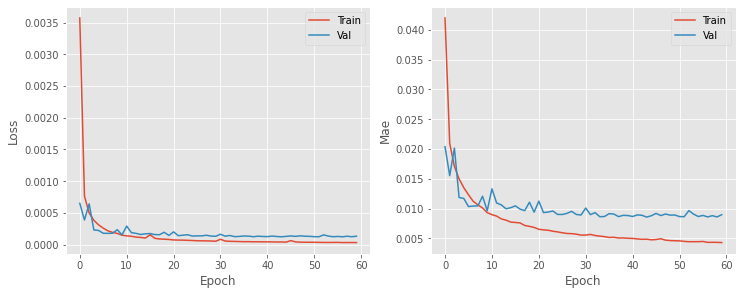

In [ ]:
plot_metrics_csv(BASE_DIR + "Results augmentation 3/history.csv").show()

In [ ]:
model = keras.models.load_model(BASE_DIR + "Results augmentation 3/model-059.h5")

In [ ]:
show_model_performances(model,[train_generator])

Train set
	Mean Squared Error : 3.233001916669309e-05
	Mean Absolute Error : 0.004297610837966204
	Average euclidean distance
		0.91 voxels
		0.92 millimeters
	Single point average euclidean distance
		Point 0 : 0.93 millimeters
		Point 1 : 0.99 millimeters
		Point 2 : 0.93 millimeters
		Point 3 : 0.84 millimeters



In [ ]:
show_model_performances(model,[validation_generator,test_generator])

Validation set
	Mean Squared Error : 0.00012422355939634144
	Mean Absolute Error : 0.008592396974563599
	Average euclidean distance
		1.95 voxels
		1.92 millimeters
	Single point average euclidean distance
		Point 0 : 2.24 millimeters
		Point 1 : 2.17 millimeters
		Point 2 : 1.66 millimeters
		Point 3 : 1.60 millimeters

Test set
	Mean Squared Error : 0.00012221837823744863
	Mean Absolute Error : 0.008810175582766533
	Average euclidean distance
		1.98 voxels
		1.95 millimeters
	Single point average euclidean distance
		Point 0 : 2.23 millimeters
		Point 1 : 2.08 millimeters
		Point 2 : 1.74 millimeters
		Point 3 : 1.74 millimeters



In [ ]:
validation_volumes, validation_targets, validation_filenames = generate_dataset(BASE_DIR + "Validation/")
validation_generator = Generator(validation_volumes,validation_targets,validation_filenames,"Validation")

  0%|          | 0/91 [00:00<?, ?it/s]

In [ ]:
create_obj_files("Predictions_val_augmentation2",model,validation_generator)

In [ ]:
test_volumes, test_targets, test_filenames = generate_dataset(BASE_DIR + "Test/")
test_generator = Generator(test_volumes, test_targets, test_filenames,"Test")

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
create_obj_files("Predictions_test_augmentation2",model,test_generator)

For the presentation

In [ ]:
print("Training set")
print("\tMean Squared Error : 0.00003")
print("\tMean Absolute Error : " + str(0.004))
print("\tAverage Euclidean Distance")
print("\t\t" + str(format(0.92,'.2f')) + " millimeters")

Training set
	Mean Squared Error : 0.00003
	Mean Absolute Error : 0.004
	Average Euclidean Distance
		0.92 millimeters


In [ ]:
print("Validation set")
print("\tMean Squared Error : 0.0001")
print("\tMean Absolute Error : " + str(0.008))
print("\tAverage Euclidean Distance")
print("\t\t" + str(format(1.92,'.2f')) + " millimeters")

Validation set
	Mean Squared Error : 0.0001
	Mean Absolute Error : 0.008
	Average Euclidean Distance
		1.92 millimeters


In [ ]:
print("Test set")
print("\tMean Squared Error : 0.0001")
print("\tMean Absolute Error : " + str(0.008))
print("\tAverage Euclidean Distance")
print("\t\t" + str(format(1.95,'.2f')) + " millimeters")

Test set
	Mean Squared Error : 0.0001
	Mean Absolute Error : 0.008
	Average Euclidean Distance
		1.95 millimeters


### Results analysis

Validation set

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    specs=[
           [{"type": "bar"},{"type": "bar"}]
           ],
    column_widths=[0.4, 0.7],
    subplot_titles=["Validation MAE","Validation AED and Single-Point AED (mm)"]
)

fig.add_trace(go.Bar(x=[""],y=[0.012],name="No Augmentation",text=["0.012"],marker_color='indianred'), row=1, col=1)
fig.add_trace(go.Bar(x=[""],y=[0.010],name="Augmentation 1",text=["0.010"],marker_color='salmon'), row=1, col=1)
fig.add_trace(go.Bar(x=[""],y=[0.008],name="Augmentation 2",text=["0.008"],marker_color='lightsalmon'), row=1, col=1)

fig.add_trace(go.Bar(x=["AED","AED key-point A","AED key-point B","AED key-point C","AED key-point D"],y=[2.82,2.51,2.91,2.73,3.11],name="No Augmentation",text=["2.82","2.51","2.91","2.73","3.11"],marker_color='indianred'), row=1, col=2)
fig.add_trace(go.Bar(x=["AED","AED key-point A","AED key-point B","AED key-point C","AED key-point D"],y=[2.29,2.42,2.61,2.00,2.13],name="Augmentation 1",text=["2.29","2.42","2.61","2.00","2.13"],marker_color='salmon'), row=1, col=2)
fig.add_trace(go.Bar(x=["AED","AED key-point A","AED key-point B","AED key-point C","AED key-point D"],y=[1.92,2.24,2.17,1.66,1.60],name="Augmentation 2",text=["1.92","2.24","2.17","1.66","1.60"],marker_color='lightsalmon'), row=1, col=2)

fig.update_traces(textfont_size=20)

Test set

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    specs=[
           [{"type": "bar"},{"type": "bar"}]
           ],
    column_widths=[0.4, 0.7],
    subplot_titles=["Test MAE","Test AED and Single-Point AED (mm)"]
)

fig.add_trace(go.Bar(x=[""],y=[0.012],name="No Augmentation",text=["0.012"],marker_color='darkblue'), row=1, col=1)
fig.add_trace(go.Bar(x=[""],y=[0.010],name="Augmentation 1",text=["0.010"],marker_color='cornflowerblue'), row=1, col=1)
fig.add_trace(go.Bar(x=[""],y=[0.008],name="Augmentation 2",text=["0.008"],marker_color='lightblue'), row=1, col=1)

fig.add_trace(go.Bar(x=["AED","AED key-point A","AED key-point B","AED key-point C","AED key-point D"],y=[2.73,2.20,2.73,2.97,3.02],name="No Augmentation",text=["2.73","2.20","2.73","2.97","3.02"],marker_color='darkblue'), row=1, col=2)
fig.add_trace(go.Bar(x=["AED","AED key-point A","AED key-point B","AED key-point C","AED key-point D"],y=[2.27,2.19,2.10,2.29,2.51],name="Augmentation 1",text=["2.27","2.19","2.10","2.29","2.51"],marker_color='cornflowerblue'), row=1, col=2)
fig.add_trace(go.Bar(x=["AED","AED key-point A","AED key-point B","AED key-point C","AED key-point D"],y=[1.95,2.23,2.08,1.74,1.74],name="Augmentation 2",text=["1.95","2.23","2.08","1.74","1.74"],marker_color='lightblue'), row=1, col=2)

fig.update_traces(textfont_size=20)

For presentation

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    specs=[
           [{"type": "bar"},{"type": "bar"}]
           ],
    column_widths=[0.4, 0.7],
    subplot_titles=["MAE","AED and Single-Point AED (mm)"]
)

fig.add_trace(go.Bar(x=[""],y=[0.012],name="No Augmentation",text=["0.012"],marker_color='indianred'), row=1, col=1)
fig.add_trace(go.Bar(x=[""],y=[0.008],name="Augmentation",text=["0.008"],marker_color='lightsalmon'), row=1, col=1)

fig.add_trace(go.Bar(x=["AED","AED key-point A","AED key-point B","AED key-point C","AED key-point D"],y=[2.82,2.51,2.91,2.73,3.11],name="No Augmentation",text=["2.82","2.51","2.91","2.73","3.11"],marker_color='indianred'), row=1, col=2)
fig.add_trace(go.Bar(x=["AED","AED key-point A","AED key-point B","AED key-point C","AED key-point D"],y=[1.92,2.24,2.17,1.66,1.60],name="Augmentation",text=["1.92","2.24","2.17","1.66","1.60"],marker_color='lightsalmon'), row=1, col=2)

fig.update_traces(textfont_size=20)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    specs=[
           [{"type": "bar"},{"type": "bar"}]
           ],
    column_widths=[0.4, 0.7],
    subplot_titles=["Test MAE","Test AED and Single-Point AED (mm)"]
)

fig.add_trace(go.Bar(x=[""],y=[0.012],name="No Augmentation",text=["0.012"],marker_color='darkblue'), row=1, col=1)
fig.add_trace(go.Bar(x=[""],y=[0.008],name="Augmentation",text=["0.008"],marker_color='cornflowerblue'), row=1, col=1)

fig.add_trace(go.Bar(x=["AED","AED key-point A","AED key-point B","AED key-point C","AED key-point D"],y=[2.73,2.20,2.73,2.97,3.02],name="No Augmentation",text=["2.73","2.20","2.73","2.97","3.02"],marker_color='darkblue'), row=1, col=2)
fig.add_trace(go.Bar(x=["AED","AED key-point A","AED key-point B","AED key-point C","AED key-point D"],y=[1.95,2.23,2.08,1.74,1.74],name="Augmentation",text=["1.95","2.23","2.08","1.74","1.74"],marker_color='cornflowerblue'), row=1, col=2)

fig.update_traces(textfont_size=20)

### Explainability

In [ ]:
TEST_VOLUME_PATH = BASE_DIR+"Test/Volumes/IXI090-Guys-0800-T1.nii.gz"

In [ ]:
volume = read_nifti_file(TEST_VOLUME_PATH)
world2vox_affine = nib.load(TEST_VOLUME_PATH).affine
volume.astype("float32")
volume = resample_volume(volume,DEFAULT_RESAMPLING_SHAPE[0],DEFAULT_RESAMPLING_SHAPE[1],DEFAULT_RESAMPLING_SHAPE[2])
volume = normalize_volume(volume)
volume = np.expand_dims(volume,axis=-1)

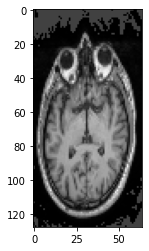

In [ ]:
plt.imshow(volume[:,64,:,0],cmap="gray") # transverse plane

In [ ]:
model = keras.models.load_model(BASE_DIR + "Results augmentation 3/model-059.h5")

In [ ]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv3D, layers.MaxPooling3D)):
        print(layer.name)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

conv3d
max_pooling3d
conv3d_1
max_pooling3d_1
conv3d_2
max_pooling3d_2
conv3d_3
max_pooling3d_3


When fed an input volume, this model returns the values of the layer activations in the original model. This model has one input and 8 outputs, one output per layer activation.

In [ ]:
layer_names

['conv3d',
 'max_pooling3d',
 'conv3d_1',
 'max_pooling3d_1',
 'conv3d_2',
 'max_pooling3d_2',
 'conv3d_3',
 'max_pooling3d_3']

In [ ]:
activation_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 30, 14, 64)   0         
 3D)                                                             
                                                             

In [ ]:
# This will return a list of 8 Numpy arrays: one array per layer activation
activations = activation_model.predict(np.expand_dims(volume,axis=0)) # add batch dimension
print(len(activations))
for out in activations:
  print(out.shape)

8
(1, 126, 126, 62, 64)
(1, 63, 63, 31, 64)
(1, 61, 61, 29, 64)
(1, 30, 30, 14, 64)
(1, 28, 28, 12, 128)
(1, 14, 14, 6, 128)
(1, 12, 12, 4, 128)
(1, 6, 6, 2, 128)


First activation with shape (1,126,126,62,64): a 126x126x62 feature map with 64 channels. Visualize one of these 64 channels:

In [ ]:
first_layer_activation = activations[0]
first_layer_activation = first_layer_activation[0]

In [ ]:
for i in range(64):
  nib.save(nib.Nifti1Image(first_layer_activation[:,:,:,i], world2vox_affine),BASE_DIR + "Explainability/FirstLayerActivation/Activation"+str(i))

In [ ]:
second_layer_activation = activations[2]
second_layer_activation = second_layer_activation[0]

In [ ]:
for i in range(64):
  nib.save(nib.Nifti1Image(second_layer_activation[:,:,:,i], world2vox_affine),BASE_DIR + "Explainability/SecondLayerActivation/Activation"+str(i))

In [ ]:
third_layer_activation = activations[4]
third_layer_activation = third_layer_activation[0]

In [ ]:
for i in range(128):
  nib.save(nib.Nifti1Image(third_layer_activation[:,:,:,i], world2vox_affine),BASE_DIR + "Explainability/ThirdLayerActivation/Activation"+str(i))

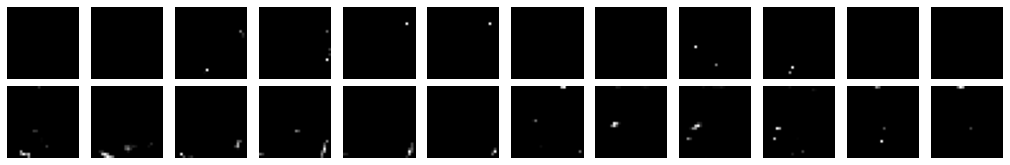

In [ ]:
num_rows = 2
num_columns = 12

heights = [28 for i in range(num_rows)]
widths = [28 for j in range(num_columns)]
fig_width = 14.0
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(
    num_rows, num_columns,
    figsize=(fig_width, fig_height),
    gridspec_kw={"height_ratios": heights},
)

for i in range(num_rows):
  for j in range(num_columns):
    axarr[i, j].imshow(np.rot90(third_layer_activation[:,:,j,i+100]), cmap="gray")
    axarr[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0.1, left=0, right=1, bottom=0.1, top=1)
plt.show()

In [ ]:
fourth_layer_activation = activations[6]
fourth_layer_activation = fourth_layer_activation[0]

In [ ]:
for i in range(128):
  nib.save(nib.Nifti1Image(fourth_layer_activation[:,:,:,i], world2vox_affine),BASE_DIR + "Explainability/FourthLayerActivation/Activation"+str(i))

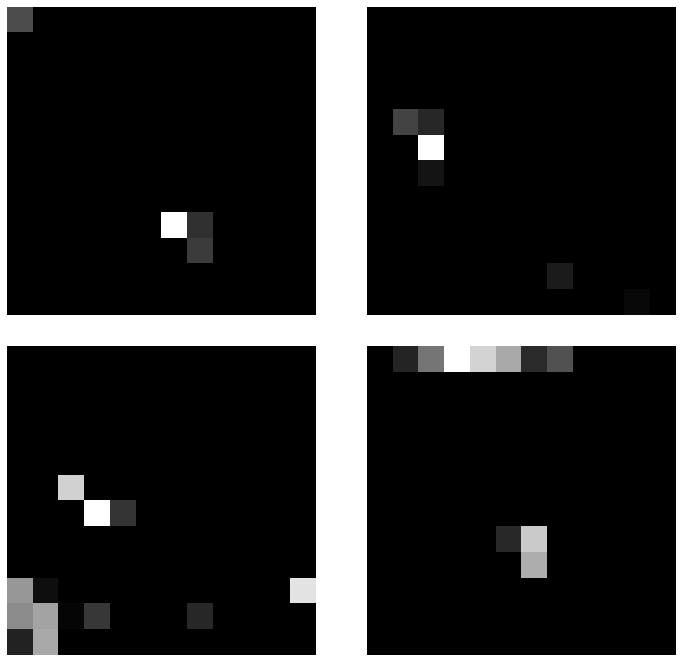

In [ ]:
num_rows = 2
num_columns = 2

heights = [12 for i in range(num_rows)]
widths = [12 for j in range(num_columns)]
fig_width = 10.0
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(
    num_rows, num_columns,
    figsize=(fig_width, fig_height),
    gridspec_kw={"height_ratios": heights},
)

for i in range(num_rows):
  for j in range(num_columns):
    index =  (i*num_columns) + j
    axarr[i, j].imshow(np.rot90(fourth_layer_activation[:,:,index,1]), cmap="gray")
    axarr[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0.1, left=0, right=1, bottom=0.1, top=1)
plt.show()

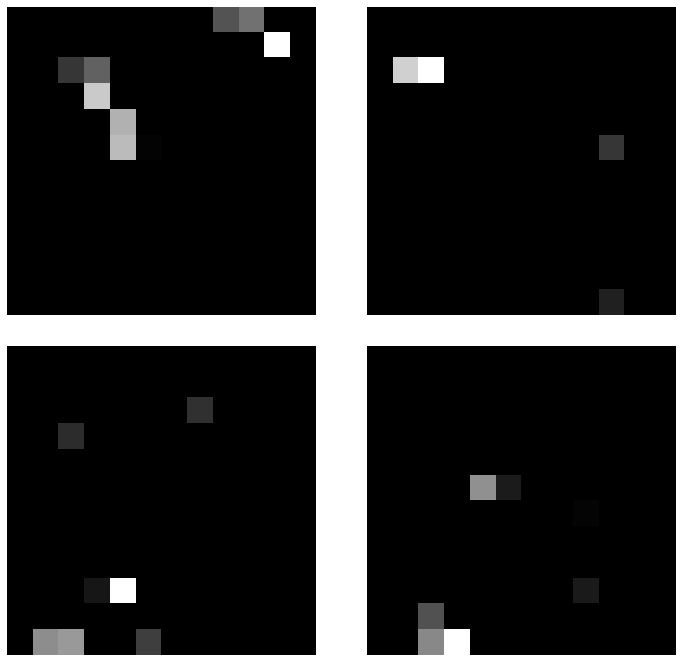

In [ ]:
num_rows = 2
num_columns = 2

heights = [12 for i in range(num_rows)]
widths = [12 for j in range(num_columns)]
fig_width = 10.0
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(
    num_rows, num_columns,
    figsize=(fig_width, fig_height),
    gridspec_kw={"height_ratios": heights},
)

for i in range(num_rows):
  for j in range(num_columns):
    index =  (i*num_columns) + j
    axarr[i, j].imshow(np.rot90(fourth_layer_activation[:,:,index,100]), cmap="gray")
    axarr[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0.1, left=0, right=1, bottom=0.1, top=1)
plt.show()

### HPO on augmented training set

Tuning results computed and stored on the *dlearning* machine. Best architecture reported below.

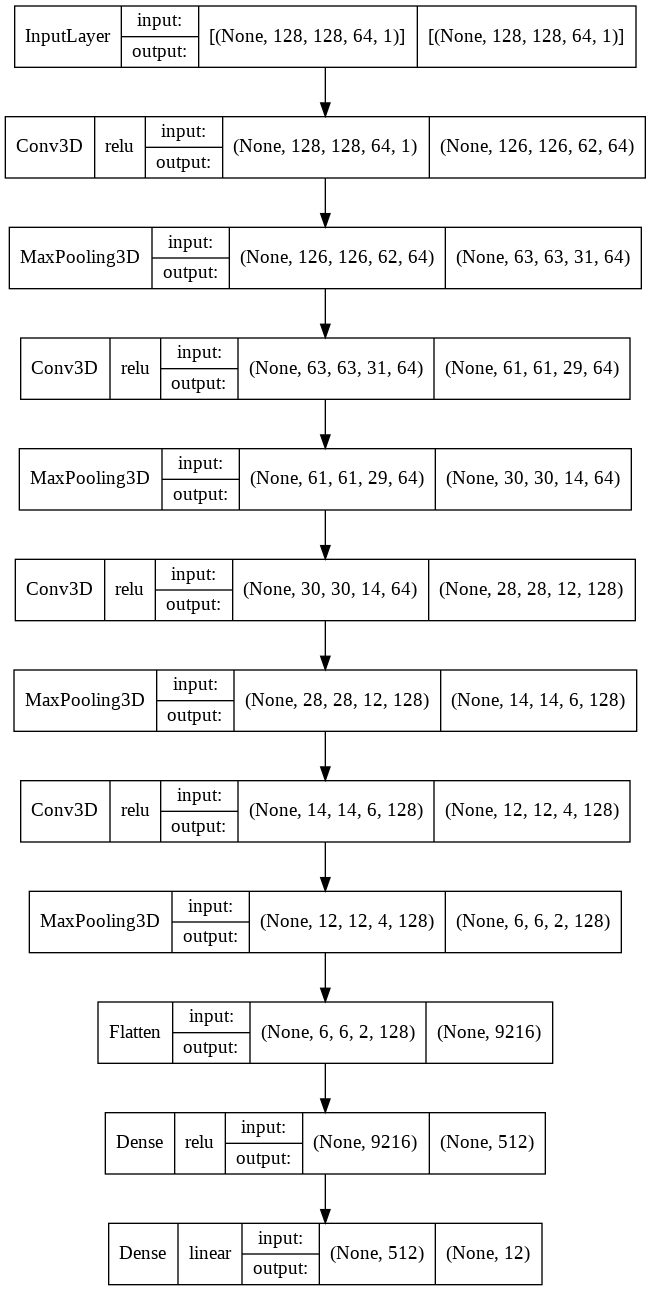

In [ ]:
inputs = keras.Input((128, 128, 64, 1))

x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPool3D(pool_size=2)(x)

x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPool3D(pool_size=2)(x)

x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPool3D(pool_size=2)(x)

x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPool3D(pool_size=2)(x)

x = layers.Flatten()(x)

x = layers.Dense(512, activation="relu")(x)

outputs = layers.Dense(12, activation="linear")(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001),loss = "mse",metrics = ["mae"])

tf.keras.utils.plot_model(model,show_shapes=True, show_layer_activations=True, show_layer_names=False)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 30, 14, 64)   0         
 3D)                                                             
                                                             

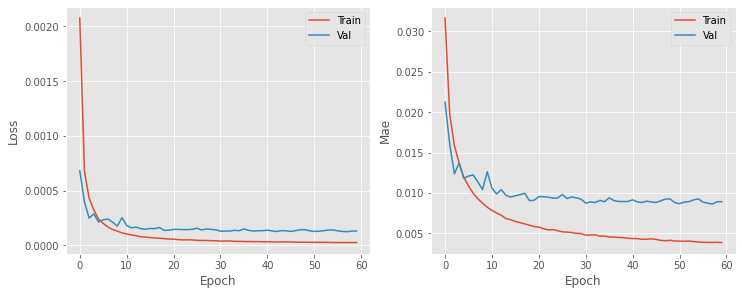

In [ ]:
plot_metrics_csv(BASE_DIR + "Augmentation2_HPO/history_augmentation_HPO.csv").show()

Performance results computed and stored on the *dlearning* machine

In [ ]:
print("Train set")
print("\tMean Squared Error : " + str(3.333001916669309e-05))
print("\tMean Absolute Error : " + str(0.004697610837966204))
print("\tAverage euclidean distance")
print("\t\t" + str(format(0.92,'.2f')) + " voxels\n\t\t"+str(format(0.93,'.2f')) + " millimeters")
print("\tSingle point average euclidean distance")
saed_mm = [0.94, 0.99, 0.94, 0.84]
for i in range(4):
  print("\t\tPoint " + str(i) + " : " + str(format(saed_mm[i],'.2f')) + " millimeters")
print()

Train set
	Mean Squared Error : 3.333001916669309e-05
	Mean Absolute Error : 0.004697610837966204
	Average euclidean distance
		0.92 voxels
		0.93 millimeters
	Single point average euclidean distance
		Point 0 : 0.94 millimeters
		Point 1 : 0.99 millimeters
		Point 2 : 0.94 millimeters
		Point 3 : 0.84 millimeters



In [ ]:
print("Validation set")
print("\tMean Squared Error : " + str(0.00013105401012580842))
print("\tMean Absolute Error : " + str(0.008922668173909187))
print("\tAverage euclidean distance")
print("\t\t" + str(format(2.00,'.2f')) + " voxels\n\t\t"+str(format(1.98,'.2f')) + " millimeters")
print("\tSingle point average euclidean distance")
saed_mm = [2.37, 2.25, 1.63, 1.66]
for i in range(4):
  print("\t\tPoint " + str(i) + " : " + str(format(saed_mm[i],'.2f')) + " millimeters")
print()

Validation set
	Mean Squared Error : 0.00013105401012580842
	Mean Absolute Error : 0.008922668173909187
	Average euclidean distance
		2.00 voxels
		1.98 millimeters
	Single point average euclidean distance
		Point 0 : 2.37 millimeters
		Point 1 : 2.25 millimeters
		Point 2 : 1.63 millimeters
		Point 3 : 1.66 millimeters



In [ ]:
print("Test set")
print("\tMean Squared Error : " + str(0.0001223729195771739))
print("\tMean Absolute Error : " + str(0.008671107701957226))
print("\tAverage euclidean distance")
print("\t\t" + str(format(1.98,'.2f')) + " voxels\n\t\t"+str(format(1.95,'.2f')) + " millimeters")
print("\tSingle point average euclidean distance")
saed_mm = [2.21, 2.16, 1.71, 1.72]
for i in range(4):
  print("\t\tPoint " + str(i) + " : " + str(format(saed_mm[i],'.2f')) + " millimeters")
print()

Test set
	Mean Squared Error : 0.0001223729195771739
	Mean Absolute Error : 0.008671107701957226
	Average euclidean distance
		1.98 voxels
		1.95 millimeters
	Single point average euclidean distance
		Point 0 : 2.21 millimeters
		Point 1 : 2.16 millimeters
		Point 2 : 1.71 millimeters
		Point 3 : 1.72 millimeters



# T1- and T2-weighted volumes

## Create Training-Validation-Test sets for T2-weighted volumes

In [ ]:
print(str(len(os.listdir(BASE_DIR + "IXI-T2/"))) + " T2-weighted volumes")

504 T2-weighted volumes


Check that all the T2-weighted volumes have a correspondent T1-weighted volume (to use its coordinates)

In [ ]:
T1_filenames = os.listdir(BASE_DIR + "Training/Volumes")+os.listdir(BASE_DIR + "Validation/Volumes")+os.listdir(BASE_DIR + "Test/Volumes") # get the names of all the 507 T1 volumes
T2_filenames = os.listdir(BASE_DIR + "IXI-T2/")
for T2_vol in T2_filenames:
  if vol[:-8]+"1.nii.gz" not in T1_filenames:
    print(T2_vol)

Split the available data in training and test set, storing them in 2 different folders on disk.

In [ ]:
T2_volumes_list = os.listdir(BASE_DIR + "IXI-T2/")
n_T2 = len(T2_volumes_list)

In [ ]:
os.mkdir(BASE_DIR + "Training_T2")
os.mkdir(BASE_DIR + "Training_T2/Volumes")
os.mkdir(BASE_DIR + "Training_T2i/Annotations")

os.mkdir(BASE_DIR + "Test_T2")
os.mkdir(BASE_DIR + "Test_T2/Volumes")
os.mkdir(BASE_DIR + "Test_T2/Annotations")

In [ ]:
num_test_samples = round(n_T2*0.1) #  90% training set - 10% test set
indexes_list = np.array(range(n_T2))
random.shuffle(indexes_list)
# create two non overlapping indexes lists
test_indexes = indexes_list[:num_test_samples]
train_indexes = indexes_list[num_test_samples:]

In [ ]:
train_annotations=os.listdir(BASE_DIR + "Training/Annotations")
validation_annotations=os.listdir(BASE_DIR + "Validation/Annotations")
test_annotations=os.listdir(BASE_DIR + "Test/Annotations")

def get_folder(filename):
  if filename in train_annotations:
    return "Train"
  elif filename in validation_annotations:
    return "Validation"
  else:
    return "Test"

Training set

In [ ]:
for i in train_indexes:
  volume_filename = T2_volumes_list[i]
  # get the annotation related to this volume (the one related to the correspondent T1 volume)
  annotation_filename = volume_filename[:-8]+"1_annot.json"
  shutil.copy(BASE_DIR+"IXI-T2/"+volume_filename,BASE_DIR + "Training_T2/Volumes/")
  folder_name = get_folder(annotation_filename) #folder to enter to get the annotation
  shutil.copy(BASE_DIR+folder_name+"/Annotations/"+annotation_filename,BASE_DIR + "Training_T2/Annotations/"+volume_filename[:-8]+"2_annot.json")

Test set

In [ ]:
for i in test_indexes:
  volume_filename = T2_volumes_list[i]
  # get the annotation related to this volume (the one related to the correspondent T1 volume)
  annotation_filename = volume_filename[:-8]+"1_annot.json"
  shutil.copy(BASE_DIR+"IXI-T2/"+volume_filename,BASE_DIR + "Test_T2/Volumes/")
  folder_name = get_folder(annotation_filename) #folder to enter to get the annotation
  shutil.copy(BASE_DIR+folder_name+"/Annotations/"+annotation_filename,BASE_DIR + "Test_T2/Annotations/"+volume_filename[:-8]+"2_annot.json")

Check the number of training and test samples:


*   Training set: 0.9x504 = 454
*   Test set: 0.1x504 = 50



In [ ]:
n_train_volumes = len(os.listdir(BASE_DIR + "Training_T2/Volumes/"))
n_train_annotations = len(os.listdir(BASE_DIR + "Training_T2/Annotations/"))
n_test_volumes = len(os.listdir(BASE_DIR + "Test_T2/Volumes/"))
n_test_annotations = len(os.listdir(BASE_DIR + "Test_T2/Annotations/"))

print(str(n_train_volumes) + " train volumes")
print(str(n_train_annotations) + " train annotations")
print(str(n_test_volumes) + " test volumes")
print(str(n_test_annotations) + " test annotations")

454 train volumes
454 train annotations
50 test volumes
50 test annotations


Create training and validation sets. The data stored in the "Train_T2" directory are splitted in training and validation sets with a split percentage of 80%-20%

In [ ]:
filenames_list = os.listdir(BASE_DIR + "Training_T2/Volumes")
n_volumes = len(filenames_list)
print("Available training-validation samples = " + str(n_volumes))

Available training-validation samples = 454


In [ ]:
count_HH = 0
count_Guys = 0
for volume in os.listdir(BASE_DIR + "Training_T2/Volumes/"):
  if "HH" in volume:
    count_HH += 1
  elif "Guys" in volume:
    count_Guys += 1
print("Train-validation volumes")
print("HH volumes : " + str(count_HH))
print("Guys volumes : " + str(count_Guys))

Train-validation volumes
HH volumes : 163
Guys volumes : 291


*   Number of training samples : 454*0.8 = 363
*   Number of validation samples : 454*0.2 = 91


In [ ]:
num_validation_samples = round(n_volumes*0.2) #  80% training set - 20% validation set
indexes_list = np.array(range(n_volumes))
random.shuffle(indexes_list)
# create two non overlapping indexes lists
validation_indexes = indexes_list[:num_validation_samples]
train_indexes = indexes_list[num_validation_samples:]

Move the validation samples in the "Validation_T2" folder

In [ ]:
os.mkdir(BASE_DIR + "Validation_T2")
os.mkdir(BASE_DIR + "Validation_T2/Volumes")
os.mkdir(BASE_DIR + "Validation_T2/Annotations")

In [ ]:
shutil.rmtree(BASE_DIR + "Validation_T2")

In [ ]:
for i in validation_indexes:
  volume_filename = filenames_list[i]
  # get the annotation related to this volume (the one related to the correspondent T1 volume)
  annotation_filename = volume_filename[:-7]+"_annot.json"
  shutil.move(BASE_DIR+"Training_T2/Volumes/"+volume_filename,BASE_DIR + "Validation_T2/Volumes/")
  #folder_name = get_folder(annotation_filename) #folder to enter to get the annotation
  shutil.move(BASE_DIR+"Training_T2/Annotations/"+annotation_filename,BASE_DIR + "Validation_T2/Annotations/")

In [ ]:
n_train_volumes = len(os.listdir(BASE_DIR + "Training_T2/Volumes/"))
n_train_annotations = len(os.listdir(BASE_DIR + "Training_T2/Annotations/"))
n_validation_volumes = len(os.listdir(BASE_DIR + "Validation_T2/Volumes/"))
n_validation_annotations = len(os.listdir(BASE_DIR + "Validation_T2/Annotations/"))

print(str(n_train_volumes) + " train volumes")
print(str(n_train_annotations) + " train annotations")
print(str(n_validation_volumes) + " validation volumes")
print(str(n_validation_annotations) + " validation annotations")

363 train volumes
363 train annotations
91 validation volumes
91 validation annotations


In [ ]:
count_HH = 0
count_Guys = 0
for volume in os.listdir(BASE_DIR + "Training_T2/Volumes/"):
  if "HH" in volume:
    count_HH += 1
  elif "Guys" in volume:
    count_Guys += 1
print("Train volumes")
print("HH volumes : " + str(count_HH))
print("Guys volumes : " + str(count_Guys))

count_HH = 0
count_Guys = 0
for volume in os.listdir(BASE_DIR + "Validation_T2/Volumes/"):
  if "HH" in volume:
    count_HH += 1
  elif "Guys" in volume:
    count_Guys += 1
print("Validation volumes")
print("HH volumes : " + str(count_HH))
print("Guys volumes : " + str(count_Guys))

Train volumes
HH volumes : 132
Guys volumes : 231
Validation volumes
HH volumes : 31
Guys volumes : 60


Check that the 2 sets are not overlapped

In [ ]:
train_volumes = os.listdir(BASE_DIR+"Training_T2/Volumes")
validation_volumes = os.listdir(BASE_DIR+"Validation_T2/Volumes")
for train_vol in train_volumes:
  if train_vol in validation_volumes:
    print(train_vol)

Save the filenames to file

In [ ]:
train_volumes = [vol+"\n" for vol in os.listdir(BASE_DIR+"Training_T2/Volumes")]
F = open("train_volumes_T2.txt", "a")
F.writelines(train_volumes)
F.close()

In [ ]:
validation_volumes = [vol+"\n" for vol in os.listdir(BASE_DIR+"Validation_T2/Volumes")]
F = open("validation_volumes_T2.txt", "a")
F.writelines(validation_volumes)
F.close()

In [ ]:
test_volumes = [vol+"\n" for vol in os.listdir(BASE_DIR+"Test_T2/Volumes")]
F = open("test_volumes_T2.txt", "a")
F.writelines(test_volumes)
F.close()

## Experiments - No augmentation

### Models and Training-Validation-Test sets

In [ ]:
def generate_T1_T2_dataset(folder_path):

  volumes, targets, filenames = generate_dataset(BASE_DIR + folder_path + "/") # T1
  volumes_T2, targets_T2, filenames_T2 = generate_dataset(BASE_DIR + folder_path + "_T2/") # T2
  volumes.extend(volumes_T2)
  targets.extend(targets_T2)
  filenames.extend(filenames_T2)

  return volumes, targets, filenames

In [ ]:
def hyper_scratch():

  inputs = keras.Input((128, 128, 64, 1))

  x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
  x = layers.MaxPool3D(pool_size=2)(x)

  x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPool3D(pool_size=2)(x)

  x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPool3D(pool_size=2)(x)

  x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPool3D(pool_size=2)(x)

  x = layers.Flatten()(x)

  x = layers.Dense(2048, activation="relu")(x)
  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dense(128, activation="relu")(x)

  outputs = layers.Dense(12, activation="linear")(x)

  model = keras.Model(inputs, outputs)

  model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001),loss = "mse",metrics = ["mae"])

  return model

In [ ]:
def hyper_densenet():

  densenet_3d = DenseNet121(
    input_shape = (128,128,64,1),
    include_top = False,
    base_channel = 16
  )

  inputs = keras.Input(shape=(128,128,64,1))
  x = densenet_3d(inputs)
  x = layers.Flatten()(x)
  x = layers.Dense(2048, activation='relu')(x)
  outputs = layers.Dense(12, activation="linear")(x)

  model = keras.Model(inputs, outputs)

  model.compile(loss="mse", metrics=["mae"], optimizer = keras.optimizers.Adam(learning_rate=0.0001))

  return model

In [ ]:
train_volumes, train_targets, train_filenames = generate_T1_T2_dataset("Training")
train_generator = Generator(train_volumes,train_targets,train_filenames,"Training")

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

In [ ]:
validation_volumes, validation_targets, validation_filenames = generate_T1_T2_dataset("Validation")
validation_generator = Generator(validation_volumes,validation_targets,validation_filenames,"Validation")

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

In [ ]:
test_volumes, test_targets, test_filenames = generate_T1_T2_dataset("Test")
test_generator = Generator(test_volumes,test_targets,test_filenames,"Test")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
validation_volumes, validation_targets, validation_filenames = generate_T1_T2_dataset("Validation")
validation_generator = Generator(validation_volumes,validation_targets,validation_filenames,"Validation")

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

In [ ]:
test_volumes, test_targets, test_filenames = generate_T1_T2_dataset("Test")
test_generator = Generator(test_volumes,test_targets,test_filenames,"Test")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### Training

In [ ]:
model = hyper_scratch()
history = model.fit(train_generator,validation_data=validation_generator,epochs = 30)

Epoch 1/30
365/365 [==============================] - 78s 175ms/step - loss: 0.0067 - mae: 0.0532 - val_loss: 0.0018 - val_mae: 0.0317
Epoch 2/30
365/365 [==============================] - 67s 182ms/step - loss: 0.0014 - mae: 0.0281 - val_loss: 0.0015 - val_mae: 0.0283
Epoch 3/30
365/365 [==============================] - 67s 184ms/step - loss: 9.1838e-04 - mae: 0.0231 - val_loss: 0.0011 - val_mae: 0.0240
Epoch 4/30
365/365 [==============================] - 66s 182ms/step - loss: 7.4438e-04 - mae: 0.0209 - val_loss: 9.8897e-04 - val_mae: 0.0232
Epoch 5/30
365/365 [==============================] - 66s 182ms/step - loss: 6.8969e-04 - mae: 0.0200 - val_loss: 8.3804e-04 - val_mae: 0.0210
Epoch 6/30
365/365 [==============================] - 66s 182ms/step - loss: 6.1626e-04 - mae: 0.0189 - val_loss: 9.2658e-04 - val_mae: 0.0220
Epoch 7/30
365/365 [==============================] - 66s 182ms/step - loss: 4.7391e-04 - mae: 0.0168 - val_loss: 6.8684e-04 - val_mae: 0.0187
Epoch 8/30
365/365 

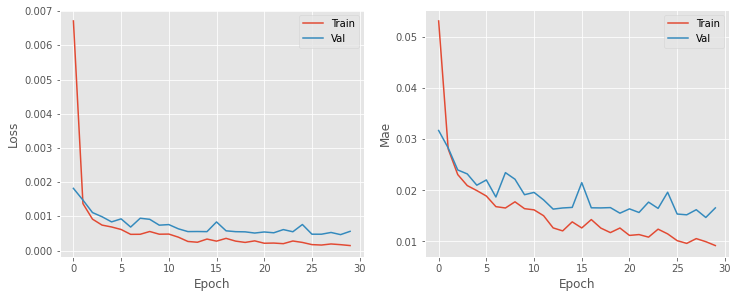

In [ ]:
plot_metrics(history).show()

In [ ]:
model.save(BASE_DIR+"hyper_scratch_T1_T2.h5")

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs = 30)

Epoch 1/30
365/365 [==============================] - 67s 182ms/step - loss: 1.6546e-04 - mae: 0.0097 - val_loss: 5.0762e-04 - val_mae: 0.0154
Epoch 2/30
365/365 [==============================] - 66s 181ms/step - loss: 1.4918e-04 - mae: 0.0093 - val_loss: 4.6030e-04 - val_mae: 0.0148
Epoch 3/30
365/365 [==============================] - 66s 180ms/step - loss: 1.5098e-04 - mae: 0.0092 - val_loss: 5.9194e-04 - val_mae: 0.0167
Epoch 4/30
365/365 [==============================] - 66s 181ms/step - loss: 1.7403e-04 - mae: 0.0099 - val_loss: 5.1352e-04 - val_mae: 0.0153
Epoch 5/30
365/365 [==============================] - 68s 185ms/step - loss: 1.3065e-04 - mae: 0.0087 - val_loss: 4.5061e-04 - val_mae: 0.0148
Epoch 6/30
365/365 [==============================] - 66s 181ms/step - loss: 1.0789e-04 - mae: 0.0079 - val_loss: 5.1437e-04 - val_mae: 0.0156
Epoch 7/30
365/365 [==============================] - 68s 186ms/step - loss: 1.0973e-04 - mae: 0.0079 - val_loss: 5.0287e-04 - val_mae: 0.0155

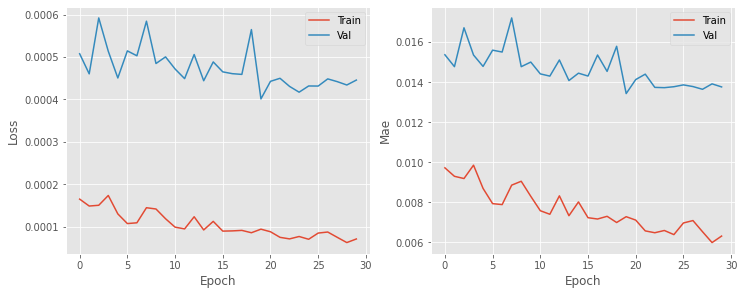

In [ ]:
plot_metrics(history).show()

In [ ]:
model.save(BASE_DIR+"hyper_scratch_T1_T2.h5")

In [ ]:
show_model_performances(model,[train_generator,validation_generator,test_generator])

Train set
	Mean Squared Error : 5.262023478280753e-05
	Mean Absolute Error : 0.005509944166988134
	Average euclidean distance
		1.22 voxels
		1.20 millimeters
	Single point average euclidean distance
		Point 0 : 0.96 millimeters
		Point 1 : 0.90 millimeters
		Point 2 : 1.52 millimeters
		Point 3 : 1.42 millimeters

Validation set
	Mean Squared Error : 0.00044567135046236217
	Mean Absolute Error : 0.01375494059175253
	Average euclidean distance
		2.88 voxels
		2.94 millimeters
	Single point average euclidean distance
		Point 0 : 2.93 millimeters
		Point 1 : 2.75 millimeters
		Point 2 : 3.03 millimeters
		Point 3 : 3.05 millimeters

Test set
	Mean Squared Error : 0.0004180852265562862
	Mean Absolute Error : 0.013838399201631546
	Average euclidean distance
		2.93 voxels
		2.98 millimeters
	Single point average euclidean distance
		Point 0 : 2.79 millimeters
		Point 1 : 2.63 millimeters
		Point 2 : 3.20 millimeters
		Point 3 : 3.29 millimeters



In [ ]:
def T1_T2_performances(model,generator):

  generator_indices = generator.indices
  actual_outputs = copy.deepcopy(generator.target)
  actual_outputs = [actual_outputs[i] for i in generator_indices] # reorder
  filenames_list = copy.deepcopy(generator.filepath)
  filenames_list = [filenames_list[i] for i in generator_indices] # reorder
  predictions = model.predict(generator)

  # considet a vector with 2 entries: one for the performances on the T1 volumes and one for the T2 volumes
  average_euclidean_distance_voxel = [0,0]
  average_euclidean_distance_mm = [0,0]
  point_average_euclidean_distance_mm = [[0,0,0,0],[0,0,0,0]] # average euclidean distance for each of the 4 points
  # 0: T1 volume, 1: T2 volume
  T1_T2_index = 0

  for actual_output, prediction, filename in zip(actual_outputs,predictions,filenames_list):

    # T1 or T2 volume ?
    if "T1" in filename:
      T1_T2_index = 0
    else:
      T1_T2_index = 1

    # get volume shape to denormalize the coordinates
    width, height, depth = read_nifti_file(filename).shape

    # denormalize
    prediction = denormalize_voxel_coords(prediction, width, height, depth)
    actual_output = denormalize_voxel_coords(actual_output, width, height, depth)

    # voxel coordinates
    average_euclidean_distance_single_prediction_voxel, _ = compute_euclidean_distance(actual_output,prediction)
    average_euclidean_distance_voxel[T1_T2_index] += average_euclidean_distance_single_prediction_voxel

    # to world coordinates
    prediction[:3] = get_world_coordinates(filename,prediction[:3])
    prediction[3:6] = get_world_coordinates(filename,prediction[3:6])
    prediction[6:9] = get_world_coordinates(filename,prediction[6:9])
    prediction[9:] = get_world_coordinates(filename,prediction[9:])
    actual_output[:3] = get_world_coordinates(filename,actual_output[:3])
    actual_output[3:6] = get_world_coordinates(filename,actual_output[3:6])
    actual_output[6:9] = get_world_coordinates(filename,actual_output[6:9])
    actual_output[9:] = get_world_coordinates(filename,actual_output[9:])

    average_euclidean_distance_single_prediction, euclidean_distance_single_point = compute_euclidean_distance(actual_output,prediction) #mean euclidean distance for a single prediction
    average_euclidean_distance_mm[T1_T2_index] += average_euclidean_distance_single_prediction
    for i in range(4):
      point_average_euclidean_distance_mm[T1_T2_index][i] += euclidean_distance_single_point[i]

  T1_predictions = len([filename for filename in filenames_list if "T1" in filename])
  T2_predictions = len([filename for filename in filenames_list if "T2" in filename])
  average_euclidean_distance_voxel[0] /= T1_predictions
  average_euclidean_distance_mm[0] /= T1_predictions
  average_euclidean_distance_voxel[1] /= T2_predictions
  average_euclidean_distance_mm[1] /= T2_predictions

  for i in range(4):
    point_average_euclidean_distance_mm[0][i] /= T1_predictions
  for i in range(4):
    point_average_euclidean_distance_mm[1][i] /= T2_predictions

  return average_euclidean_distance_voxel, average_euclidean_distance_mm, point_average_euclidean_distance_mm

In [ ]:
def show_T1_T2_performances(model,generators_list):

  for generator in generators_list:

      average_euclidean_distance_voxel, average_euclidean_distance_mm, point_average_euclidean_distance_mm = T1_T2_performances(model,generator)
      print(generator.name + " set")
      print("\tAverage euclidean distance on T1 volumes")
      print("\t\t" + str(format(average_euclidean_distance_voxel[0],'.2f')) + " voxels\n\t\t" + str(format(average_euclidean_distance_mm[0],'.2f')) + " millimeters")
      print("\t\tSingle point average euclidean distance on T1 volumes")
      for i in range(4):
        print("\t\t\tPoint " + str(i) + " : " + str(format(point_average_euclidean_distance_mm[0][i],'.2f')) + " millimeters")
      print()
      print("\tAverage euclidean distance on T2 volumes")
      print("\t\t" + str(format(average_euclidean_distance_voxel[1],'.2f')) + " voxels\n\t\t" + str(format(average_euclidean_distance_mm[1],'.2f')) + " millimeters")
      print("\t\tSingle point average euclidean distance on T2 volumes")
      for i in range(4):
        print("\t\t\tPoint " + str(i) + " : " + str(format(point_average_euclidean_distance_mm[1][i],'.2f')) + " millimeters")
      print()

In [ ]:
show_T1_T2_performances(model,[train_generator,validation_generator,test_generator])

Train set
	Average euclidean distance on T1 volumes
		1.23 voxels
		1.18 millimeters
		Single point average euclidean distance on T1 volumes
			Point 0 : 0.95 millimeters
			Point 1 : 1.04 millimeters
			Point 2 : 1.53 millimeters
			Point 3 : 1.20 millimeters

	Average euclidean distance on T2 volumes
		1.22 voxels
		1.22 millimeters
		Single point average euclidean distance on T2 volumes
			Point 0 : 0.97 millimeters
			Point 1 : 0.76 millimeters
			Point 2 : 1.51 millimeters
			Point 3 : 1.65 millimeters

Validation set
	Average euclidean distance on T1 volumes
		2.82 voxels
		2.76 millimeters
		Single point average euclidean distance on T1 volumes
			Point 0 : 2.66 millimeters
			Point 1 : 2.82 millimeters
			Point 2 : 2.70 millimeters
			Point 3 : 2.85 millimeters

	Average euclidean distance on T2 volumes
		2.95 voxels
		3.12 millimeters
		Single point average euclidean distance on T2 volumes
			Point 0 : 3.19 millimeters
			Point 1 : 2.67 millimeters
			Point 2 : 3.36 millimeter

In [ ]:
test_set_obj_files("hyper_scratch_T1_T2_predictions",model,test_generator)

## Experiments - Augmentation

#### Create T2 augmented training set, in the same manner used for the T1 augmented training set

In [ ]:
len(os.listdir(BASE_DIR+"Training_T2/Volumes"))

363

In [ ]:
os.mkdir(BASE_DIR + "AugmentedTraining_T2/")
os.mkdir(BASE_DIR + "AugmentedTraining_T2/Volumes/")
os.mkdir(BASE_DIR + "AugmentedTraining_T2/Annotations/")

In [ ]:
volumes_names = os.listdir(BASE_DIR + "Training_T2/Volumes")
rotation_angles = np.arange(-10,11) # expressed in degrees. Smaller values than the T1 case, because the T2 volumes are half heads
translation_values = np.arange(-5,6) # expressed in voxels

rotation_angles_indexes = np.arange(20)
tx_indexes = np.arange(10)
ty_indexes = np.arange(10)
tz_indexes = np.arange(10)

for volume_name,i in zip(volumes_names,tqdm(range(len(volumes_names)))):

  volume = read_nifti_file(BASE_DIR + "Training_T2/Volumes/" + volume_name)
  world2vox_affine = nib.load(BASE_DIR + "Training_T2/Volumes/" + volume_name).affine
  annotation_path = BASE_DIR + "Training_T2/Annotations/" + volume_name[:-7] + "_annot.json"

  for axis in ["x","y","z"]:

    np.random.shuffle(rotation_angles_indexes)
    np.random.shuffle(tx_indexes)
    np.random.shuffle(ty_indexes)
    np.random.shuffle(tz_indexes)

    for i in range(7): # 7 roto-translation for each one of the 3 axis -> 21 roto-translation for each volume

      rotation_angle = rotation_angles[rotation_angles_indexes[i]]
      tx = translation_values[tx_indexes[i]]
      ty = translation_values[ty_indexes[i]]
      tz = translation_values[tz_indexes[i]]

      augmentation_affine_matrix = create_augmentation_affine_matrix(axis,rotation_angle,tx,ty,tz)

      augmentation_affine_matrix_inverse = np.linalg.inv(augmentation_affine_matrix) # invert the matrix to use the ndimage.affine_transform method

      # apply the transformation to the original volume
      augmented_volume = ndimage.affine_transform(volume,augmentation_affine_matrix_inverse,output_shape=volume.shape)

      # save the augmented volume into a Nifti file
      augmented_volume_name = volume_name[:-7] + "_" + axis + "_" + str(rotation_angle) + "_" + str(tx) + "_" + str(ty) + "_" + str(tz) + ".nii.gz"
      nib.save(nib.Nifti1Image(augmented_volume, world2vox_affine),BASE_DIR + "AugmentedTraining_T2/Volumes/"+augmented_volume_name)

      # modify the target coordinates
      augmented_annotation_name = augmented_volume_name[:-7] + "_annot.json"
      augment_coordinates(volume_name, augmentation_affine_matrix,BASE_DIR + "AugmentedTraining_T2/Annotations/"+augmented_annotation_name,T2=True)


  0%|          | 0/363 [00:00<?, ?it/s]

In [ ]:
len(os.listdir(BASE_DIR+"AugmentedTrain_T2/Volumes"))
len(os.listdir(BASE_DIR+"AugmentedTrain_T2/Annotations"))

6212

In [ ]:
train_volumes = [v.split(".")[0] for v in os.listdir(BASE_DIR+"Training_T2/Volumes")]
aug_volumes = os.listdir(BASE_DIR+"AugmentedTraining_T2/Volumes")
count = {}
for vol in train_volumes:
  count[vol] = len([v for v in aug_volumes if vol in v])

n = 0
for key in count:
  if count[key] != 21:
    print(key + " \t" + str(count[key]))

21
IXI150-HH-1550-T2 	17
IXI298-Guys-0861-T2 	0
IXI527-HH-2376-T2 	0
IXI157-Guys-0816-T2 	0
IXI618-Guys-1091-T2 	0
IXI386-HH-2077-T2 	0
IXI166-Guys-0846-T2 	0
IXI121-Guys-0772-T2 	0
IXI228-Guys-0822-T2 	0
IXI644-Guys-1121-T2 	0
IXI019-Guys-0702-T2 	0
IXI613-HH-2734-T2 	0
IXI393-Guys-0941-T2 	0
IXI160-HH-1637-T2 	0
IXI225-Guys-0832-T2 	0
IXI207-Guys-0809-T2 	0
IXI467-Guys-0983-T2 	0
IXI139-Guys-0815-T2 	0
IXI389-Guys-0930-T2 	0
IXI158-Guys-0783-T2 	0
IXI093-HH-1359-T2 	0
IXI084-Guys-0741-T2 	0
IXI661-HH-2788-T2 	0
IXI408-Guys-0962-T2 	0
IXI321-Guys-0903-T2 	0
IXI079-HH-1388-T2 	0
IXI324-Guys-0922-T2 	0
IXI186-Guys-0796-T2 	0
IXI120-Guys-0766-T2 	0
IXI492-Guys-1022-T2 	0
IXI012-HH-1211-T2 	0
IXI578-Guys-1078-T2 	0
IXI250-Guys-0836-T2 	0
IXI057-HH-1342-T2 	0
IXI338-HH-1971-T2 	0
IXI046-Guys-0824-T2 	0
IXI027-Guys-0710-T2 	0
IXI244-Guys-0841-T2 	0
IXI369-Guys-0924-T2 	0
IXI002-Guys-0828-T2 	0
IXI441-HH-2154-T2 	0
IXI299-Guys-0893-T2 	0
IXI589-Guys-1080-T2 	0
IXI662-Guys-1120-T2 	0
IXI379-G

In [ ]:
os.listdir(BASE_DIR + "Training_T2/Volumes")[295]

'IXI150-HH-1550-T2.nii.gz'

In [ ]:
aug_volumes = os.listdir(BASE_DIR+"AugmentedTraining_T2/Volumes")
for v in aug_volumes:
  if "IXI150-HH-1550-T2" in v:
    os.remove(BASE_DIR+"AugmentedTraining_T2/Volumes/"+v)

aug_annotations = os.listdir(BASE_DIR+"AugmentedTraining_T2/Annotations")
for v in aug_annotations:
  if "IXI150-HH-1550-T2" in v:
    os.remove(BASE_DIR+"AugmentedTraining_T2/Annotations/"+v)

In [ ]:
print(len(os.listdir(BASE_DIR+"AugmentedTraining_T2/Volumes")))
print(len(os.listdir(BASE_DIR+"AugmentedTraining_T2/Annotations")))

6195
6195


... augment the remaining volumes

In [ ]:
volumes_names = os.listdir(BASE_DIR + "Training_T2/Volumes")[295:]
rotation_angles = np.arange(-10,11) # expressed in degrees. Smaller values than the T1 case, because the T2 volumes are half heads
translation_values = np.arange(-5,6) # expressed in voxels

rotation_angles_indexes = np.arange(20)
tx_indexes = np.arange(10)
ty_indexes = np.arange(10)
tz_indexes = np.arange(10)

for volume_name,i in zip(volumes_names,tqdm(range(len(volumes_names)))):

  volume = read_nifti_file(BASE_DIR + "Training_T2/Volumes/" + volume_name)
  world2vox_affine = nib.load(BASE_DIR + "Training_T2/Volumes/" + volume_name).affine
  annotation_path = BASE_DIR + "Training_T2/Annotations/" + volume_name[:-7] + "_annot.json"

  for axis in ["x","y","z"]:

    np.random.shuffle(rotation_angles_indexes)
    np.random.shuffle(tx_indexes)
    np.random.shuffle(ty_indexes)
    np.random.shuffle(tz_indexes)

    for i in range(7): # 7 roto-translation for each one of the 3 axis -> 21 roto-translation for each volume

      rotation_angle = rotation_angles[rotation_angles_indexes[i]]
      tx = translation_values[tx_indexes[i]]
      ty = translation_values[ty_indexes[i]]
      tz = translation_values[tz_indexes[i]]

      augmentation_affine_matrix = create_augmentation_affine_matrix(axis,rotation_angle,tx,ty,tz)

      augmentation_affine_matrix_inverse = np.linalg.inv(augmentation_affine_matrix) # invert the matrix to use the ndimage.affine_transform method

      # apply the transformation to the original volume
      augmented_volume = ndimage.affine_transform(volume,augmentation_affine_matrix_inverse,output_shape=volume.shape)

      # save the augmented volume into a Nifti file
      augmented_volume_name = volume_name[:-7] + "_" + axis + "_" + str(rotation_angle) + "_" + str(tx) + "_" + str(ty) + "_" + str(tz) + ".nii.gz"
      nib.save(nib.Nifti1Image(augmented_volume, world2vox_affine),BASE_DIR + "AugmentedTraining_T2/Volumes/"+augmented_volume_name)

      # modify the target coordinates
      augmented_annotation_name = augmented_volume_name[:-7] + "_annot.json"
      augment_coordinates(volume_name, augmentation_affine_matrix,BASE_DIR + "AugmentedTraining_T2/Annotations/"+augmented_annotation_name,T2=True)

  0%|          | 0/68 [00:00<?, ?it/s]

Finally, produce a roto-translation on 3 different general axes, for each original volume

In [ ]:
volumes_names = os.listdir(BASE_DIR + "Training_T2/Volumes")
rotation_angles = np.arange(-10,11) # expressed in degrees. Smaller values than the T1 case, because the T2 volumes are half heads
translation_values = np.arange(-5,6) # expressed in voxels

rotation_angles_indexes = np.arange(20)
tx_indexes = np.arange(10)
ty_indexes = np.arange(10)
tz_indexes = np.arange(10)

for volume_name,i in zip(volumes_names,tqdm(range(len(volumes_names)))):

  volume = read_nifti_file(BASE_DIR + "Training_T2/Volumes/" + volume_name)
  world2vox_affine = nib.load(BASE_DIR + "Training_T2/Volumes/" + volume_name).affine
  annotation_path = BASE_DIR + "Training_T2/Annotations/" + volume_name[:-7] + "_annot.json"

  for j in range(3):

    # general axis for the rotation
    general_axis = np.random.uniform(-1, 1, 3) # 3 random floats between -1 and 1
    while np.sum(general_axis) == 1.0: # avoid canonical axes
      general_axis = np.random.uniform(-1, 1, 3)

    np.random.shuffle(rotation_angles_indexes)
    np.random.shuffle(tx_indexes)
    np.random.shuffle(ty_indexes)
    np.random.shuffle(tz_indexes)

    rotation_angle = rotation_angles[rotation_angles_indexes[0]]
    tx = translation_values[tx_indexes[0]]
    ty = translation_values[ty_indexes[0]]
    tz = translation_values[tz_indexes[0]]

    augmentation_affine_matrix = create_augmentation_affine_matrix("general", rotation_angle, tx, ty, tz, general_axis=general_axis)

    augmentation_affine_matrix_inverse = np.linalg.inv(augmentation_affine_matrix) # invert the matrix to use the ndimage.affine_transform method

    # apply the transformation to the original volume
    augmented_volume = ndimage.affine_transform(volume,augmentation_affine_matrix_inverse,output_shape=volume.shape)

    # save the augmented volume into a Nifti file
    augmented_volume_name = volume_name[:-7] + "_" + str(general_axis) + "_" + str(rotation_angle) + "_" + str(tx) + "_" + str(ty) + "_" + str(tz) + ".nii.gz"
    nib.save(nib.Nifti1Image(augmented_volume, world2vox_affine),BASE_DIR + "AugmentedTraining_T2/Volumes/"+augmented_volume_name)

    # modify the target coordinates
    augmented_annotation_name = augmented_volume_name[:-7] + "_annot.json"
    augment_coordinates(volume_name, augmentation_affine_matrix,BASE_DIR + "AugmentedTraining_T2/Annotations/"+augmented_annotation_name,T2=True)

  0%|          | 0/363 [00:00<?, ?it/s]

In [ ]:
print(len(os.listdir(BASE_DIR+"AugmentedTraining_T2/Volumes")))
print(len(os.listdir(BASE_DIR+"AugmentedTraining_T2/Annotations")))

8712
8712


#### Create a H5 file containing the pre-processed AugmentedTraining_T2 + Training_T2

Insert the original 363 volumes

In [ ]:
train_volumes_chunk, train_targets_chunk, train_filenames_chunk = generate_dataset(BASE_DIR + "Training_T2/")

with h5py.File(BASE_DIR + "preprocessed_augmentedtrain_T2.h5", 'w') as hf:
  hf.create_dataset("volumes", data=train_volumes_chunk,maxshape=(None,128,128,64,1))
  hf.create_dataset("targets", data=train_targets_chunk,maxshape=(None,12))
  hf.create_dataset("filenames", data=train_filenames_chunk,maxshape=(None,))

  0%|          | 0/363 [00:00<?, ?it/s]

Insert the augmented volumes

In [ ]:
end_idx = 7890
n_volumes = len(os.listdir(BASE_DIR + "AugmentedTraining_T2/Volumes"))
for count in range(5):

  start_idx = end_idx
  end_idx = start_idx + 526
  train_volumes_chunk, train_targets_chunk, train_filenames_chunk = generate_dataset(BASE_DIR + "AugmentedTraining_T2/",start_idx=start_idx,end_idx=end_idx)

  with h5py.File(BASE_DIR + "preprocessed_augmentedtrain_T2.h5", 'a') as hf:
    hf["volumes"].resize((len(hf["volumes"]) + len(train_volumes_chunk)), axis = 0)
    hf["volumes"][-len(train_volumes_chunk):] = train_volumes_chunk

    hf["targets"].resize((len(hf["targets"]) + len(train_targets_chunk)), axis = 0)
    hf["targets"][-len(train_targets_chunk):] = train_targets_chunk

    hf["filenames"].resize((len(hf["filenames"]) + len(train_filenames_chunk)), axis = 0)
    hf["filenames"][-len(train_filenames_chunk):] = train_filenames_chunk

  if count == 4:
    print("Restart with end_idx = " +str(end_idx))

  if end_idx >= n_volumes:
    break

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

In [ ]:
with h5py.File(BASE_DIR + "preprocessed_augmentedtrain_T2.h5", 'r') as hf:
  print(len(hf["volumes"]))
  print(len(hf["targets"]))
  print(len(hf["filenames"]))

9075
9075
9075


In [ ]:
with h5py.File(BASE_DIR + "preprocessed_augmentedtrain_T2.h5", 'r') as hf:
  coords = hf["targets"][1000]
  filename = hf["filenames"][1000]

vol = read_nifti_file(BASE_DIR + "AugmentedTraining_T2/Volumes/IXI212-HH-1643-T2_[0.95992885 0.29686435 0.50357893]_0_-2_-4_1.nii.gz")
width,height,depth = vol.shape
denormalized_coords = denormalize_voxel_coords(coords,width,height,depth)
print(denormalized_coords[:3])
print(denormalized_coords[3:6])
print(denormalized_coords[6:9])
print(denormalized_coords[9:])

[129.48273 101.44322  68.46241]
[128.21194  147.8534    78.950615]
[ 96.23988  187.3665    53.134018]
[161.49438 188.1677   54.70506]


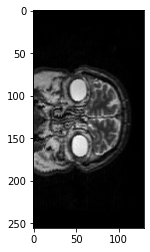

In [ ]:
plt.imshow(vol[:,188,:],cmap="gray")

#### Experiment

Performance results computed and stored on the *dlearning* machine

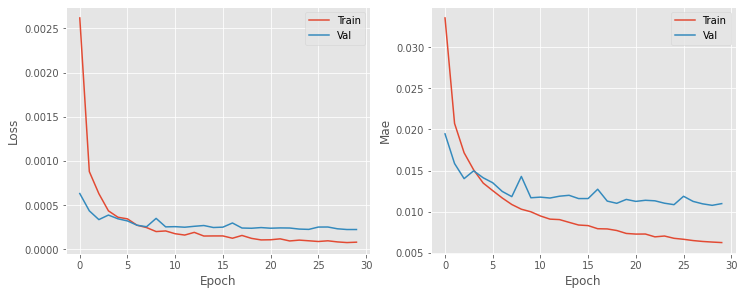

In [ ]:
plot_metrics_csv(BASE_DIR + "Results augmentation T1-T2/history.csv").show()

In [ ]:
print("Train set")
print("\tMean Squared Error : " + str(0.0000806753450888209))
print("\tMean Absolute Error : " + str(0.006251411512494087))
print("\tAverage euclidean distance")
print("\t\t" + str(format(1.38,'.2f')) + " voxels\n\t\t"+str(format(1.36,'.2f')) + " millimeters")
print("\tSingle point average euclidean distance")
saed_mm = [1.04, 1.18, 1.46, 1.6]
for i in range(4):
  print("\t\tPoint " + str(i) + " : " + str(format(saed_mm[i],'.2f')) + " millimeters")
print()

Train set
	Mean Squared Error : 8.06753450888209e-05
	Mean Absolute Error : 0.006251411512494087
	Average euclidean distance
		1.38 voxels
		1.36 millimeters
	Single point average euclidean distance
		Point 0 : 1.04 millimeters
		Point 1 : 1.18 millimeters
		Point 2 : 1.46 millimeters
		Point 3 : 1.60 millimeters



In [ ]:
print("Validation set")
print("\tMean Squared Error : " + str(0.0002238810993731022))
print("\tMean Absolute Error : " + str(0.010984922759234905))
print("\tAverage euclidean distance")
print("\t\t" + str(format(2.26,'.2f')) + " voxels\n\t\t"+str(format(2.32,'.2f')) + " millimeters")
print("\tSingle point average euclidean distance")
saed_mm = [2.72, 2.46, 2.05, 2.03]
for i in range(4):
  print("\t\tPoint " + str(i) + " : " + str(format(saed_mm[i],'.2f')) + " millimeters")
print()

Validation set
	Mean Squared Error : 0.0002238810993731022
	Mean Absolute Error : 0.010984922759234905
	Average euclidean distance
		2.26 voxels
		2.32 millimeters
	Single point average euclidean distance
		Point 0 : 2.72 millimeters
		Point 1 : 2.46 millimeters
		Point 2 : 2.05 millimeters
		Point 3 : 2.03 millimeters



In [ ]:
print("Test set")
print("\tMean Squared Error : " + str(0.000251190853305161))
print("\tMean Absolute Error : " + str(0.011401551775634289))
print("\tAverage euclidean distance")
print("\t\t" + str(format(2.37,'.2f')) + " voxels\n\t\t"+str(format(2.42,'.2f')) + " millimeters")
print("\tSingle point average euclidean distance")
saed_mm = [2.83, 2.31, 2.25, 2.27]
for i in range(4):
  print("\t\tPoint " + str(i) + " : " + str(format(saed_mm[i],'.2f')) + " millimeters")
print()

Test set
	Mean Squared Error : 0.000251190853305161
	Mean Absolute Error : 0.011401551775634289
	Average euclidean distance
		2.37 voxels
		2.42 millimeters
	Single point average euclidean distance
		Point 0 : 2.83 millimeters
		Point 1 : 2.31 millimeters
		Point 2 : 2.25 millimeters
		Point 3 : 2.27 millimeters



Performances on T1- and T2-weighted volumes

In [ ]:
print("Train set")
print("\tAverage euclidean distance on T1 volumes")
print("\t\t" + str(format(1.25,'.2f')) + " voxels\n\t\t" + str(format(1.2,'.2f')) + " millimeters")
print("\t\tSingle point average euclidean distance on T1 volumes")
saed_mm = [1.01, 1.22, 1.31, 1.26]
for i in range(4):
  print("\t\t\tPoint " + str(i) + " : " + str(format(saed_mm[i],'.2f')) + " millimeters")
print()
print("\tAverage euclidean distance on T2 volumes")
print("\t\t" + str(format(1.51,'.2f')) + " voxels\n\t\t" + str(format(1.52,'.2f')) + " millimeters")
print("\t\tSingle point average euclidean distance on T2 volumes")
saed_mm = [1.07, 1.14, 1.61, 1.94]
for i in range(4):
  print("\t\t\tPoint " + str(i) + " : " + str(format(saed_mm[i],'.2f')) + " millimeters")
print()

Train set
	Average euclidean distance on T1 volumes
		1.25 voxels
		1.20 millimeters
		Single point average euclidean distance on T1 volumes
			Point 0 : 1.01 millimeters
			Point 1 : 1.22 millimeters
			Point 2 : 1.31 millimeters
			Point 3 : 1.26 millimeters

	Average euclidean distance on T2 volumes
		1.51 voxels
		1.52 millimeters
		Single point average euclidean distance on T2 volumes
			Point 0 : 1.07 millimeters
			Point 1 : 1.14 millimeters
			Point 2 : 1.61 millimeters
			Point 3 : 1.94 millimeters



In [ ]:
print("Validation set")
print("\tAverage euclidean distance on T1 volumes")
print("\t\t" + str(format(2.24,'.2f')) + " voxels\n\t\t" + str(format(2.21,'.2f')) + " millimeters")
print("\t\tSingle point average euclidean distance on T1 volumes")
saed_mm = [2.61, 2.54, 1.83, 1.85]
for i in range(4):
  print("\t\t\tPoint " + str(i) + " : " + str(format(saed_mm[i],'.2f')) + " millimeters")
print()
print("\tAverage euclidean distance on T2 volumes")
print("\t\t" + str(format(2.29,'.2f')) + " voxels\n\t\t" + str(format(2.42,'.2f')) + " millimeters")
print("\t\tSingle point average euclidean distance on T2 volumes")
saed_mm = [2.84, 2.38, 2.27, 2.20]
for i in range(4):
  print("\t\t\tPoint " + str(i) + " : " + str(format(saed_mm[i],'.2f')) + " millimeters")
print()

Validation set
	Average euclidean distance on T1 volumes
		2.24 voxels
		2.21 millimeters
		Single point average euclidean distance on T1 volumes
			Point 0 : 2.61 millimeters
			Point 1 : 2.54 millimeters
			Point 2 : 1.83 millimeters
			Point 3 : 1.85 millimeters

	Average euclidean distance on T2 volumes
		2.29 voxels
		2.42 millimeters
		Single point average euclidean distance on T2 volumes
			Point 0 : 2.84 millimeters
			Point 1 : 2.38 millimeters
			Point 2 : 2.27 millimeters
			Point 3 : 2.20 millimeters



In [ ]:
print("Test set")
print("\tAverage euclidean distance on T1 volumes")
print("\t\t" + str(format(2.24,'.2f')) + " voxels\n\t\t" + str(format(2.23,'.2f')) + " millimeters")
print("\t\tSingle point average euclidean distance on T1 volumes")
saed_mm = [2.56, 2.28, 2.14, 1.92]
for i in range(4):
  print("\t\t\tPoint " + str(i) + " : " + str(format(saed_mm[i],'.2f')) + " millimeters")
print()
print("\tAverage euclidean distance on T2 volumes")
print("\t\t" + str(format(2.49,'.2f')) + " voxels\n\t\t" + str(format(2.60,'.2f')) + " millimeters")
print("\t\tSingle point average euclidean distance on T2 volumes")
saed_mm = [3.10, 2.35, 2.37, 2.61]
for i in range(4):
  print("\t\t\tPoint " + str(i) + " : " + str(format(saed_mm[i],'.2f')) + " millimeters")
print()

Test set
	Average euclidean distance on T1 volumes
		2.24 voxels
		2.23 millimeters
		Single point average euclidean distance on T1 volumes
			Point 0 : 2.56 millimeters
			Point 1 : 2.28 millimeters
			Point 2 : 2.14 millimeters
			Point 3 : 1.92 millimeters

	Average euclidean distance on T2 volumes
		2.49 voxels
		2.60 millimeters
		Single point average euclidean distance on T2 volumes
			Point 0 : 3.10 millimeters
			Point 1 : 2.35 millimeters
			Point 2 : 2.37 millimeters
			Point 3 : 2.61 millimeters

